In [1]:
import sys
import os
import subprocess
    
import math
import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib
import datetime

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc    


Welcome to JupyROOT 6.13/02


In [3]:
#events_data_table_name = '_old5_spb_processing_v3_flatmap.event' # unnecessary, does not apply for other tables
# events_data_table_name = '_old3_spb_processing_v3.event'

In [4]:
data_snippets_dir = 'ver4_flatmap_data_snippets'
os.makedirs(data_snippets_dir, exist_ok=True)

# Selecting data

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [6]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=[
        ('^$','^source_file_acquisition_full$'), ('^$','^source_file_acquisition$'), ('^$','^global_gtu$'), ('^$','^packet_id$'), 
        ('^$','gtu_in_packet'), ('^$','event_id'), ('^$','num_gtu'), 
        '^bg_.*', 
        ('gtu_datetime','min'), 
        ('gps_lat','mean'), ('gps_lon','mean'), ('gps_alt','mean')
    ]
)

In [7]:
removed_cols = {'spb_processing_v3.event_bg_x_y':['median','median_gz','size']}
for table,cols_list in columns_for_analysis_dict.items():
    if table not in removed_cols:
        continue
    for removed_col in removed_cols[table]:
        try:
            del cols_list[ cols_list.index(removed_col) ]
        except ValueError:
            pass
    


In [8]:
#import pprint
split_columns_for_analysis_dict = query_functions.split_to_smaller_dicts(columns_for_analysis_dict,300)
#print(select_clause_str)
for i,g in enumerate(split_columns_for_analysis_dict):
    tot_items = 0
    for k,vl in g.items():
        tot_items += len(vl)
    print(i,tot_items)
    
    for t, vl in g.items():
        sys.stdout.write(t)
        sys.stdout.write('\n\t- ')
        print('\n\t- '.join(vl))
        print()
    
    print('-'*60)

0 234
spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_acquisition
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_gps_lat
	- mean

spb_processing_v4_flatmap.event_gps_lon
	- mean

spb_processing_v4_flatmap.event_gps_alt
	- mean

spb_processing_v4_flatmap.event_gtu_datetime
	- min

spb_processing_v4_flatmap.event_bg_x_y
	- event_id
	- count_nonzero
	- sum
	- norm_sum
	- min
	- max
	- mean
	- std
	- mean_gz
	- std_gz
	- size
	- median
	- median_gz
	- width
	- height
	- area

spb_processing_v4_flatmap.event_bg_x_y_clusters
	- event_id
	- count
	- sizes_min
	- sizes_max
	- sizes_mean
	- sizes_std
	- sums_sum
	- sums_min
	- sums_max
	- sums_mean
	- sums_std
	- clu_widths_max
	- clu_heights_max
	- clu_widths_min
	- clu_widths_mean
	- clu_heights_mean
	- clu_widths_std
	- clu_heights_std
	- clu_areas_min
	- clu_areas_max
	- clu_areas_mean
	- clu_areas_std
	- max_area_clu_width
	- max_area_clu_height
	- min_area

In [9]:
current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = " AND config_info_id=1 AND source_file_acquisition NOT LIKE '%-sqz.root' AND source_file_acquisition NOT LIKE '%-sqz-dis.root'"
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=1,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=350000, offset=0,
    base_select='',
#    data_table_name_overwrite=events_data_table_name
)

print(events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_gps_lat.mean AS gps_lat_mean, spb_processing_v4_flatmap.event_gps_lon.mean AS gps_lon_mean, spb_processing_v4_flatmap.event_gps_alt.mean AS gps_alt_mean, spb_processing_v4_flatmap.event_gtu_datetime.min AS gtu_datetime_min, spb_processing_v4_flatmap.event_bg_x_y.event_id AS bg_x_y_event_id, spb_processing_v4_flatmap.event_bg_x_y.count_nonzero AS bg_x_y_count_nonzero, spb_processing_v4_flatmap.event_bg_x_y.sum AS bg_x_y_sum, spb_processing_v4_flatmap.event_bg_x_y.norm_sum AS bg_x_y_norm_sum, spb_processing_v4_flatmap.event_bg_x_y.min AS bg_x_y_min, spb_processing_v4_flatmap.event_bg_x_y.max AS bg

In [10]:
flight_data_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [11]:
prev_colwidth = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
flight_data_df[flight_data_df.source_file_acquisition_full.str.endswith(".root")]

,event_id,source_file_acquisition_full,source_file_acquisition,global_gtu,packet_id,gtu_in_packet,num_gtu,gps_lat_mean,gps_lon_mean,gps_alt_mean,...,bg_norm_sum,bg_min,bg_max,bg_mean,bg_std,bg_mean_gz,bg_std_gz,bg_size,bg_median,bg_median_gz
0,1,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,40,0,40,26,-36.7629,-171.669,30842.0,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
1,2,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,84,0,84,23,-36.7629,-171.669,30842.0,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
2,3,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,167,1,39,16,-36.7624,-171.666,30838.8,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
3,4,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,296,2,40,34,-36.7613,-171.662,30828.6,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
4,5,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,424,3,40,21,-36.7607,-171.660,30822.3,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
5,6,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,552,4,40,56,-36.7602,-171.657,30815.6,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
6,7,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,680,5,40,21,-36.7596,-171.655,30809.2,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
7,8,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,808,6,40,21,-36.7591,-171.653,30802.5,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
8,9,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-002.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-002.001--LONG.root,39,0,39,26,-36.7586,-171.651,30797.2,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000
9,10,/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170428/allpackets-SPBEUSO-ACQUISITION-20170428-063224-002.001--LONG.root,allpackets-SPBEUSO-ACQUISITION-20170428-063224-002.001--LONG.root,85,0,85,47,-36.7586,-171.651,30797.2,...,-1.00,0,0,0.00000,0.00000,-1.00000,-1.00000,36.0,0.0,-1.00000


In [12]:
pd.set_option('display.max_colwidth', prev_colwidth)

# Distributions

In [13]:
len(flight_data_df[flight_data_df.bg_size >= 36])/len(flight_data_df) # [flight_data_df.bg_size >= 36]

0.8480518888876234

In [14]:
flight_data_packets_groups = flight_data_df.groupby(['source_file_acquisition_full', 'packet_id'])

In [15]:
flight_data_packets_firstev_df = flight_data_packets_groups.first()

## All

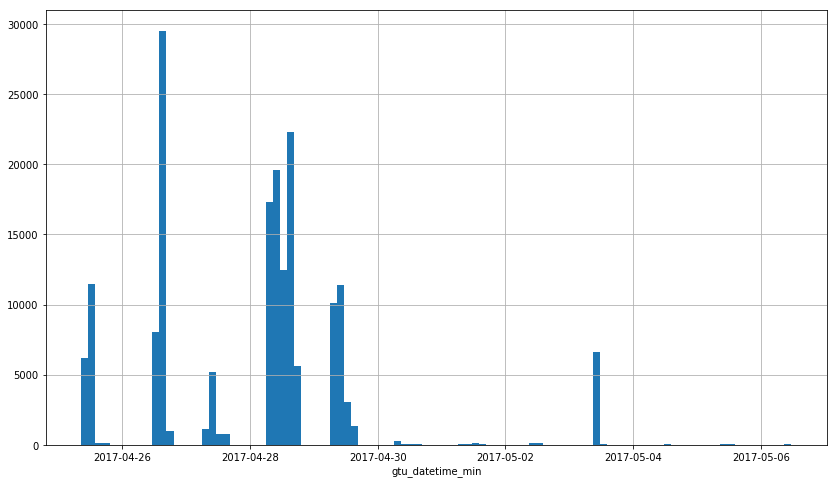

In [16]:
h = flight_data_df.gtu_datetime_min.hist(bins=100,figsize=(14,8))
h.set_xlabel('gtu_datetime_min')
plt.show()

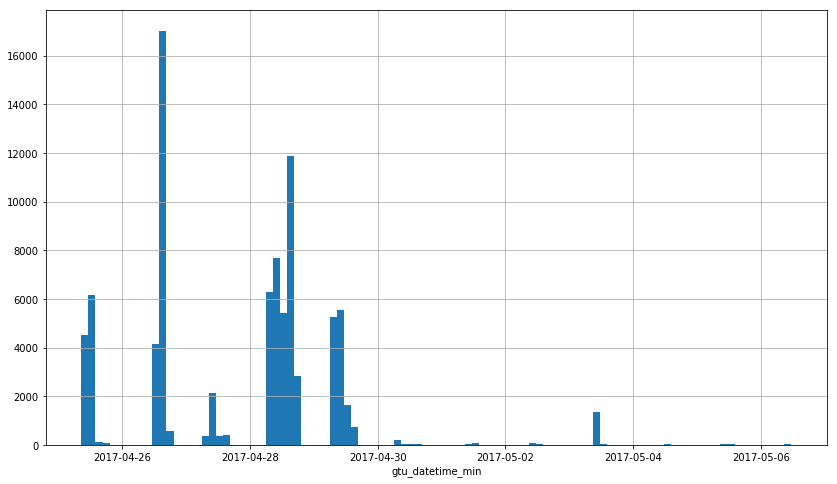

In [17]:
h = flight_data_packets_firstev_df.gtu_datetime_min.hist(bins=100,figsize=(14,8))
h.set_xlabel('gtu_datetime_min')
plt.show()

In [18]:
flight_data_df.gtu_datetime_min.min()

Timestamp('2017-04-25 08:31:48.450785')

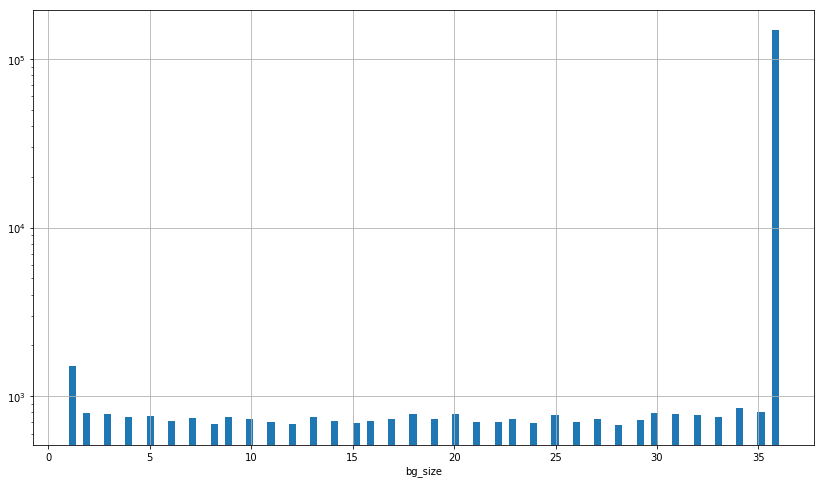

In [19]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_size.hist(bins=100,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_size')
plt.show()

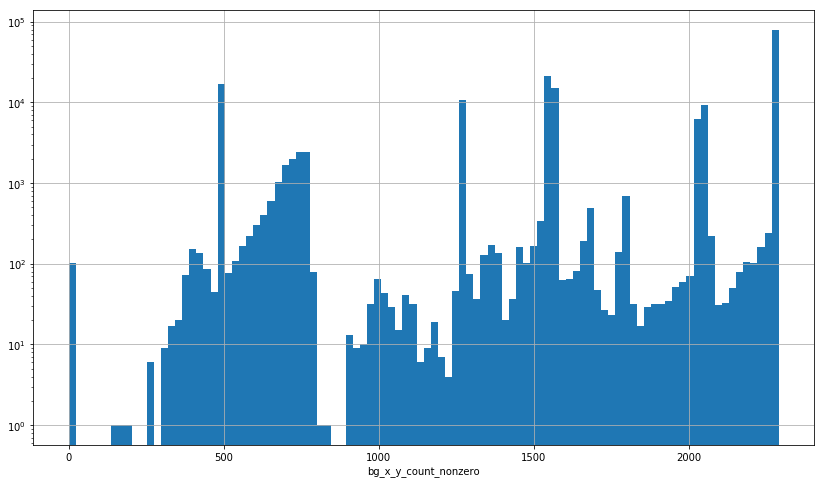

In [20]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_count_nonzero .hist(bins=100,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_x_y_count_nonzero')
plt.show()

## flight_data_df.bg_size >= 36

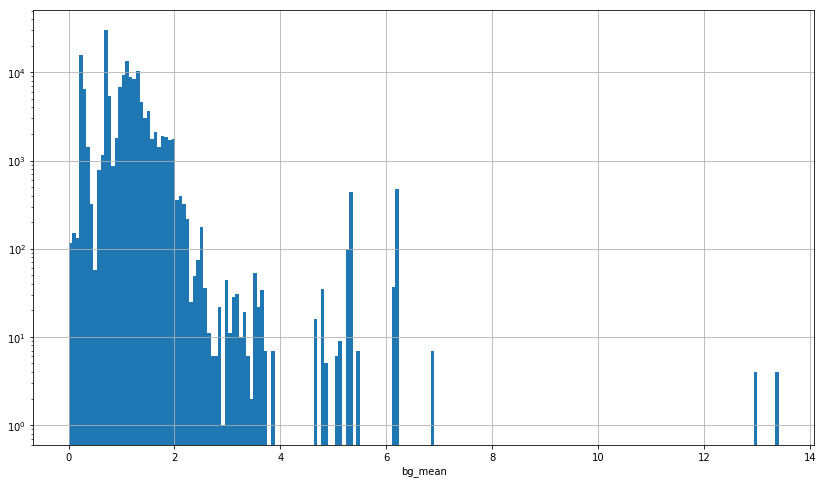

1.03158
1.0126782812701864
148923


In [21]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36)]
h = filtered_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_mean')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))

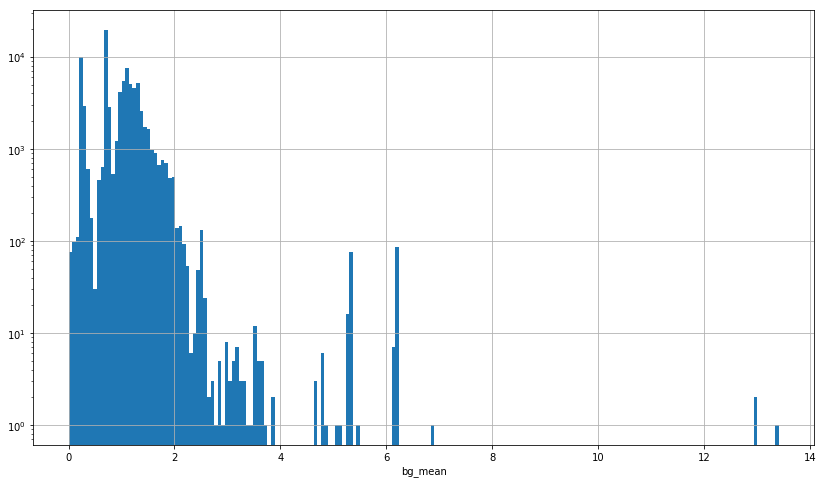

0.979273
0.942247425033297
148923


In [22]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36)]
filtered_firstev_df = filtered_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
h = filtered_firstev_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_mean')
plt.show()
print(np.median(filtered_firstev_df.bg_mean))
print(np.mean(filtered_firstev_df.bg_mean))
print(len(filtered_df))

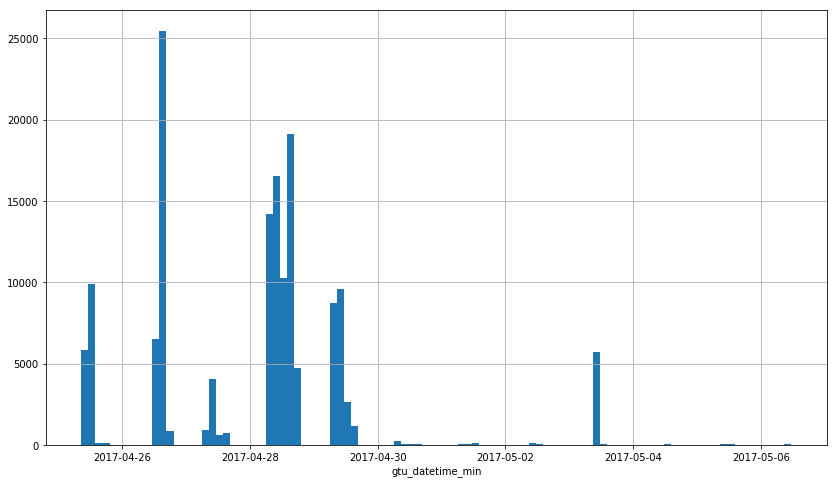

In [23]:
h = filtered_df.gtu_datetime_min.hist(bins=100,figsize=(14,8))
h.set_xlabel('gtu_datetime_min')
#h.set_yscale('log')
plt.show()

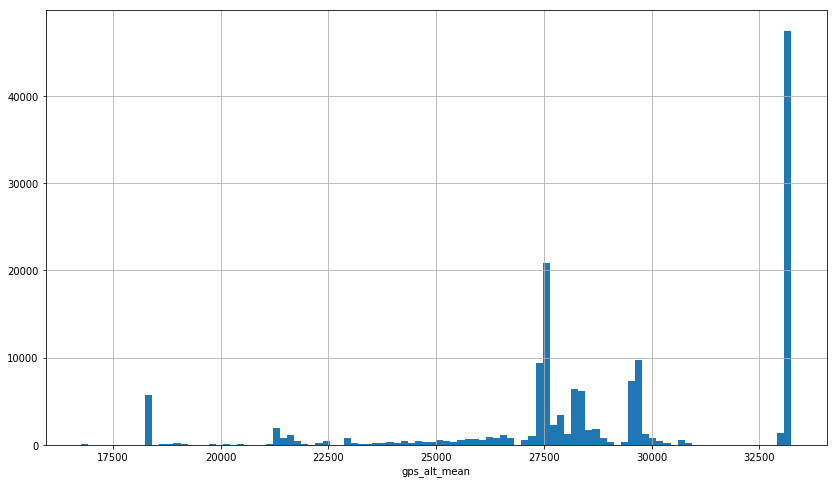

In [24]:
h = filtered_df.gps_alt_mean.hist(bins=100,figsize=(14,8))
h.set_xlabel('gps_alt_mean')
plt.show()

## (flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 38)

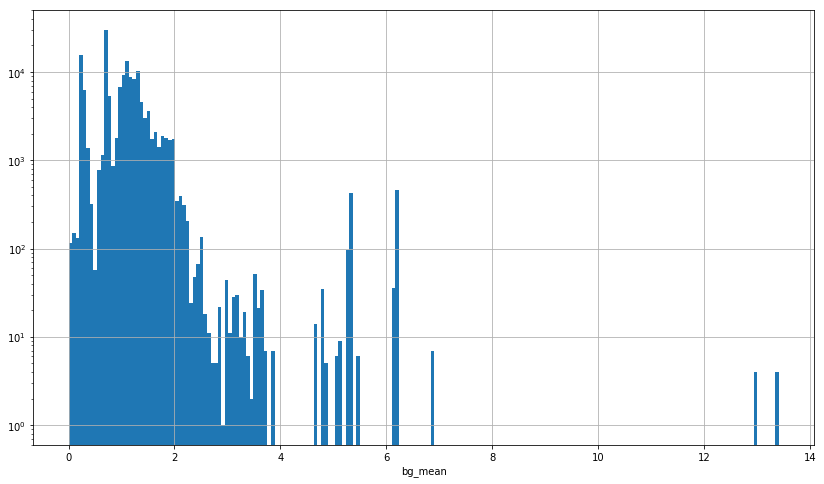

1.03054
1.0114595383693403
147008


In [25]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 38)]
h = filtered_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_mean')
plt.show()
print(np.median(filtered_df.bg_mean))
print(np.mean(filtered_df.bg_mean))
print(len(filtered_df))

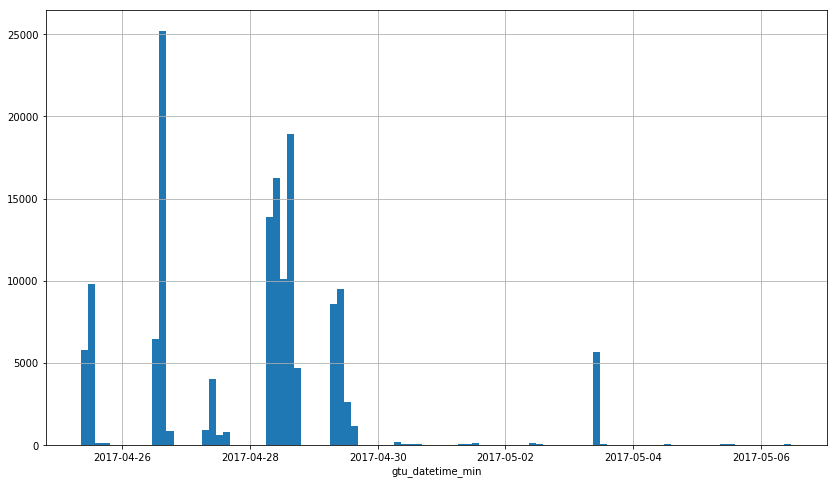

In [26]:
h = filtered_df.gtu_datetime_min.hist(bins=100,figsize=(14,8))
h.set_xlabel('gtu_datetime_min')
plt.show()

In [27]:
filtered_df.gtu_datetime_min.min()

Timestamp('2017-04-25 08:31:48.450785')

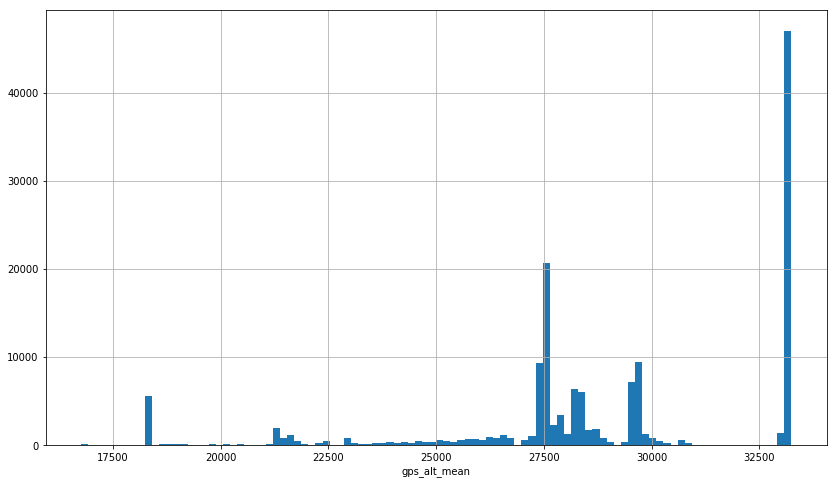

In [28]:
h = filtered_df.gps_alt_mean.hist(bins=100,figsize=(14,8))
h.set_xlabel('gps_alt_mean')
plt.show()

## Final filtration ( (flight_data_df.bg_size >= 36) & (flight_data_df.bg_x_y_count_nonzero > 2100) )

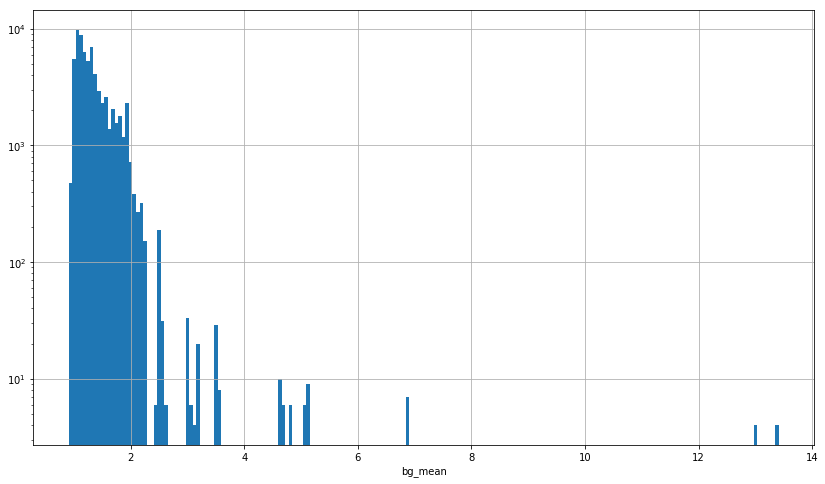

1.2606
1.336332341698956
175606 67618


In [29]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_background_selection_basename_str = 'bg_size_ge_36__bg_x_y_gt_2100'
filtered_background_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.bg_x_y_count_nonzero > 2100)]
h = filtered_background_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_mean')
plt.show()
print(np.median(filtered_background_df.bg_mean))
print(np.mean(filtered_background_df.bg_mean))
print(len(flight_data_df),len(filtered_background_df))


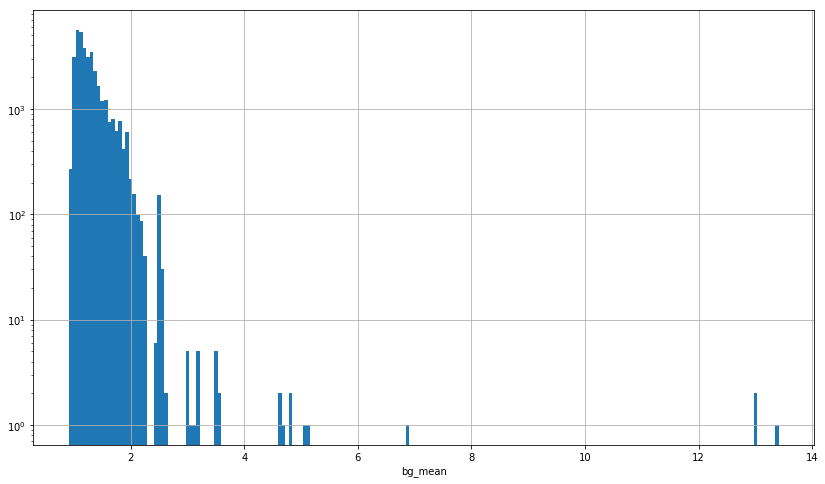

1.21579
1.2939936047166392
0.905999
13.4106
67618


In [30]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = filtered_background_df
filtered_firstev_df = filtered_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
h = filtered_firstev_df.bg_mean.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_mean')
plt.show()
print(np.median(filtered_firstev_df.bg_mean))
print(np.mean(filtered_firstev_df.bg_mean))
print(np.min(filtered_firstev_df.bg_mean))
print(np.max(filtered_firstev_df.bg_mean))
print(len(filtered_df))

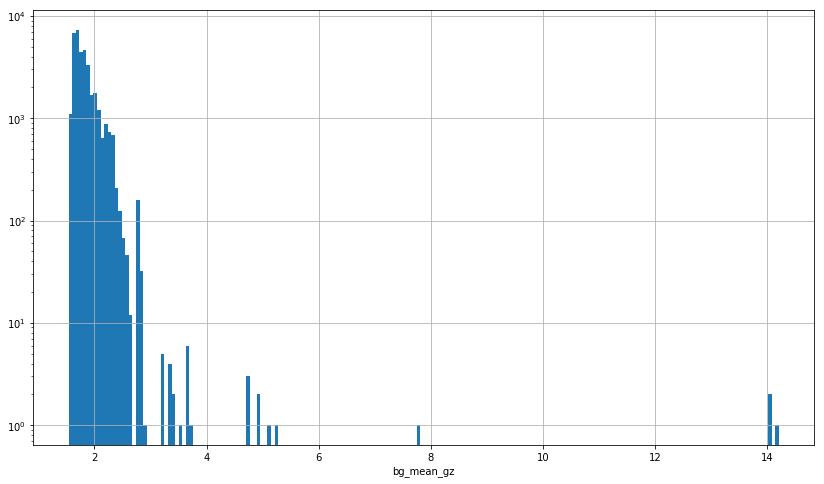

1.76528
1.8273361012460627
1.54089
14.2009
67618


In [31]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
filtered_df = filtered_background_df
filtered_firstev_df = filtered_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
h = filtered_firstev_df.bg_mean_gz.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_mean_gz')
plt.show()
print(np.median(filtered_firstev_df.bg_mean_gz))
print(np.mean(filtered_firstev_df.bg_mean_gz))
print(np.min(filtered_firstev_df.bg_mean_gz))
print(np.max(filtered_firstev_df.bg_mean_gz))
print(len(filtered_df))

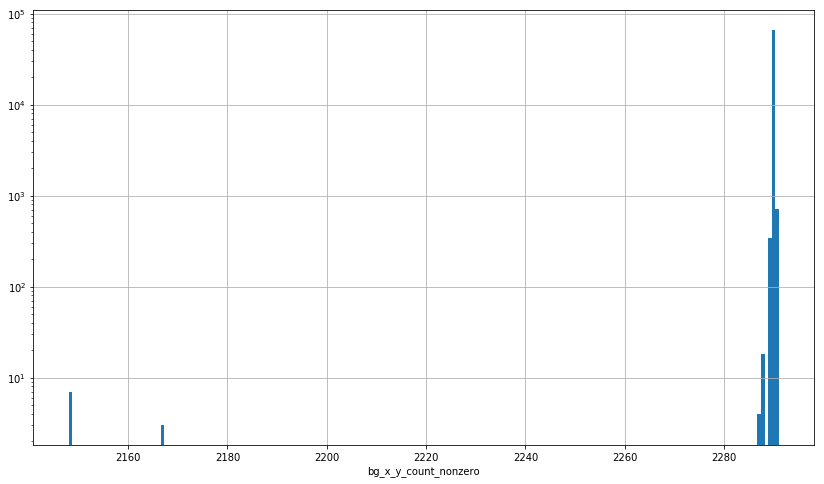

2290.0
2289.984649057943


In [32]:
h = filtered_background_df.bg_x_y_count_nonzero.hist(bins=200,figsize=(14,8))
h.set_yscale('log')
h.set_xlabel('bg_x_y_count_nonzero')
plt.show()
print(np.median(filtered_background_df.bg_x_y_count_nonzero))
print(np.mean(filtered_background_df.bg_x_y_count_nonzero))


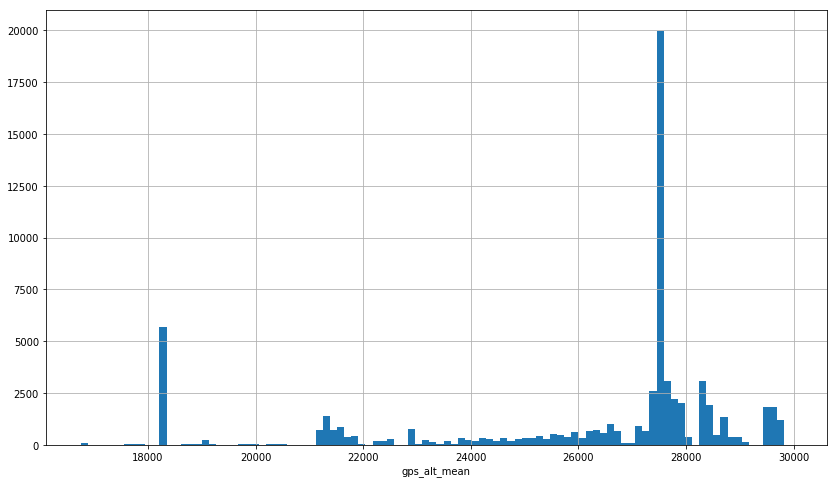

In [33]:
h = filtered_background_df.gps_alt_mean.hist(bins=100,figsize=(14,8))
h.set_xlabel('gps_alt_mean')
plt.show()

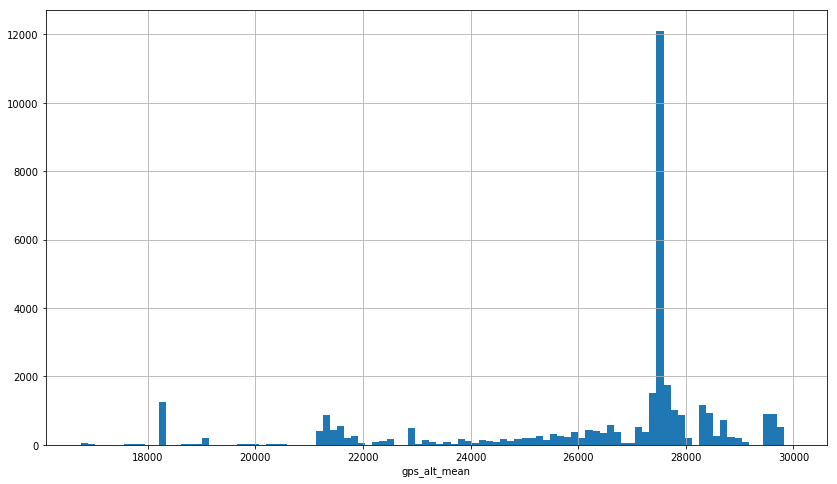

In [34]:
h = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first().gps_alt_mean.hist(bins=100,figsize=(14,8))
h.set_xlabel('gps_alt_mean')
plt.show()

In [35]:
filtered_background_df.gtu_datetime_min.min()

Timestamp('2017-04-27 08:25:12.000200')

## Altitude - background relation

0    0.00  0.50  0      nan        nan       
1    0.50  1.00  1554   21239.500  29824.000 


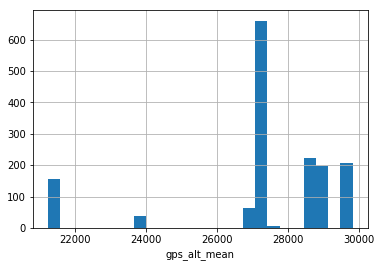

2    1.00  1.50  27570  16762.300  29824.000 


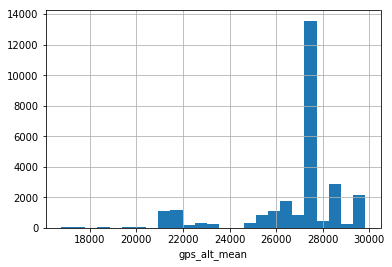

3    1.50  2.00  6118   16837.600  28377.800 


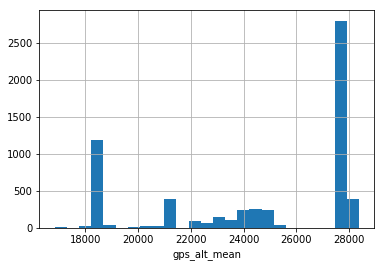

4    2.00  2.50  512    18278.800  27832.600 


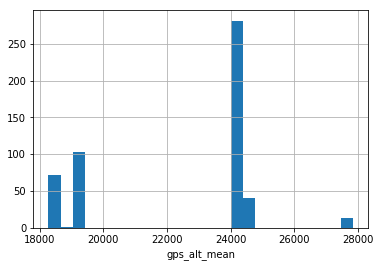

5    2.50  3.00  94     18870.100  19084.700 


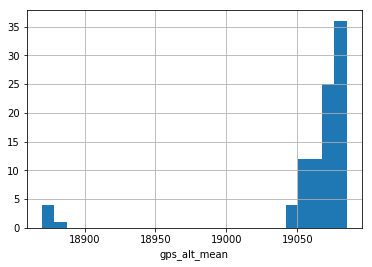

6    3.00  3.50  8      18296.600  21760.800 


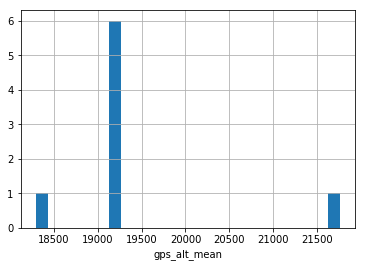

7    3.50  4.00  6      21740.900  21757.800 


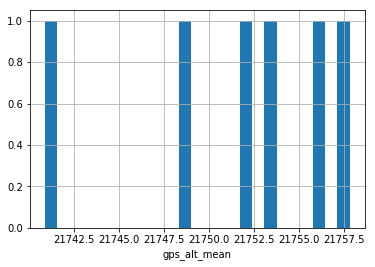

8    4.00  4.50  0      nan        nan       


In [36]:
mean_bg_mean = []
mean_gps_alt_vals = []
median_gps_alt_vals = []
quantile_025_gps_alt_vals = []
quantile_975_gps_alt_vals = []
std_gps_alt_vals = []
count_gps_alt_vals = []

filtered_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()

bin_width = 0.50
for i in range(0,math.ceil(4/bin_width)+1):
    min_v = i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean) & (filtered_df.bg_mean < max_v)]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.gps_alt_mean.min(), t_filtered_df.gps_alt_mean.max()
    ))
    if len(t_filtered_df) > 0:
        h = t_filtered_df.gps_alt_mean.hist(bins=25)
        h.set_xlabel('gps_alt_mean')
        plt.show()
        
        mean_bg_mean.append(np.mean([min_v,max_v]))
        mean_gps_alt_vals.append(t_filtered_df.gps_alt_mean.mean())
        median_gps_alt_vals.append(t_filtered_df.gps_alt_mean.median())
        quantile_025_gps_alt_vals.append(t_filtered_df.gps_alt_mean.quantile(0.025))
        quantile_975_gps_alt_vals.append(t_filtered_df.gps_alt_mean.quantile(0.975))
        std_gps_alt_vals.append(t_filtered_df.gps_alt_mean.std())
        count_gps_alt_vals.append(t_filtered_df.gps_alt_mean.count())
    
# filtered_df 

In [37]:
print('mean_bg_mean')
print(['{:.2f}'.format(v) for v in mean_bg_mean])
print('mean_gps_alt_vals')
print(['{:.2f}'.format(v) for v in mean_gps_alt_vals])
print('median_gps_alt_vals')
print(['{:.2f}'.format(v) for v in median_gps_alt_vals])
print('quantile_025_gps_alt_vals')
print(['{:.2f}'.format(v) for v in quantile_025_gps_alt_vals])
print('quantile_975_gps_alt_vals')
print(['{:.2f}'.format(v) for v in quantile_975_gps_alt_vals])
print('std_gps_alt_vals')
print(['{:.2f}'.format(v) for v in std_gps_alt_vals])
print('count_gps_alt_vals')
print(['{:.2f}'.format(v) for v in count_gps_alt_vals])

mean_bg_mean
['0.75', '1.25', '1.75', '2.25', '2.75', '3.25', '3.75']
mean_gps_alt_vals
['27337.44', '26845.27', '24519.92', '22457.72', '19060.98', '19364.89', '21751.45']
median_gps_alt_vals
['27387.90', '27483.00', '27539.10', '24178.20', '19073.10', '19143.95', '21752.65']
quantile_025_gps_alt_vals
['21299.20', '21292.65', '18279.30', '18279.18', '18875.81', '18443.18', '21741.84']
quantile_975_gps_alt_vals
['29823.50', '29604.83', '27936.20', '27815.33', '19083.80', '21303.98', '21757.61']
std_gps_alt_vals
['2313.92', '2161.28', '3826.65', '2765.76', '45.35', '1012.46', '6.14']
count_gps_alt_vals
['1554.00', '27570.00', '6118.00', '512.00', '94.00', '8.00', '6.00']


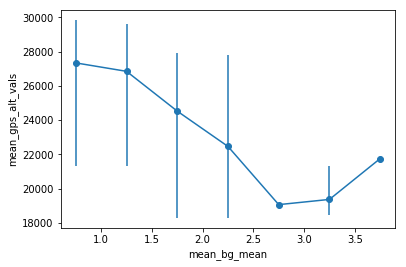

In [38]:
yerr=[np.array(mean_gps_alt_vals) - np.array(quantile_025_gps_alt_vals), 
      np.array(quantile_975_gps_alt_vals) - np.array(mean_gps_alt_vals)]
fig, ax = plt.subplots(1)
ax.errorbar(mean_bg_mean, mean_gps_alt_vals, marker='o', yerr=yerr)
ax.set_xlabel('mean_bg_mean')
ax.set_ylabel('mean_gps_alt_vals')
plt.show()

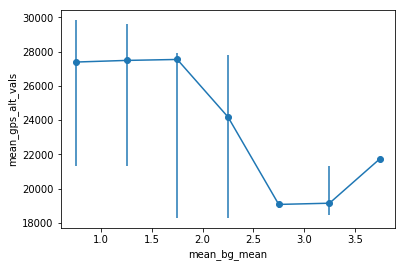

In [39]:
yerr=[np.array(median_gps_alt_vals) - np.array(quantile_025_gps_alt_vals), 
      np.array(quantile_975_gps_alt_vals) - np.array(median_gps_alt_vals)]
fig, ax = plt.subplots(1)
ax.errorbar(mean_bg_mean, median_gps_alt_vals, marker='o', yerr=yerr)
ax.set_xlabel('mean_bg_mean')
ax.set_ylabel('mean_gps_alt_vals')
plt.show()

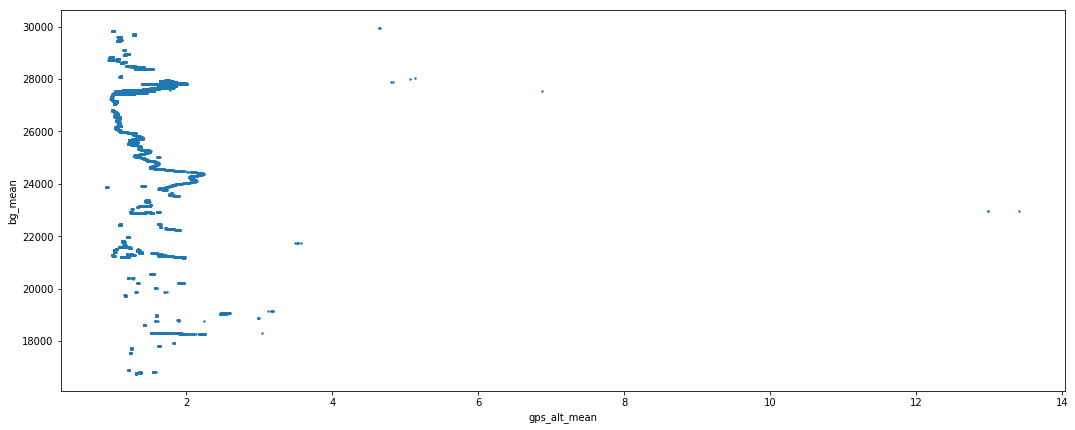

In [40]:
plt.close('all')
fig, ax = plt.subplots(1)
fig.set_size_inches(18,7)
filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
ax.scatter(x=filtered_firstev_df['bg_mean'], y=filtered_firstev_df['gps_alt_mean'],s=2)
ax.set_ylabel('bg_mean')
ax.set_xlabel('gps_alt_mean')
# filtered_background_df.plot.scatter(x='gtu_datetime_min',y='bg_mean')
plt.show()

In [41]:
# probably not correct
# inspired by https://machinelearningmastery.com/confidence-intervals-for-machine-learning/
def bootstrap_quantiles(df, p, bootstrap_size=100):
    means = np.zeros(bootstrap_size)
    for i in range(bootstrap_size):
        indices = np.random.randint(0, len(df), 500)
        means[i]=df.iloc[indices][p].mean()
    return np.percentile(means,2.5),np.percentile(means,50),np.percentile(means,97.5)

0    16000.00 18000.00 138    1.204      1.839     


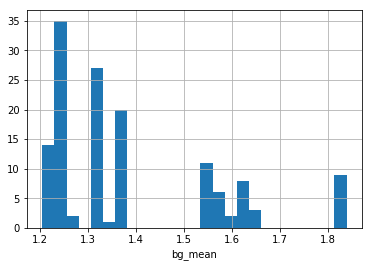

1    18000.00 20000.00 1588   1.154      3.192     


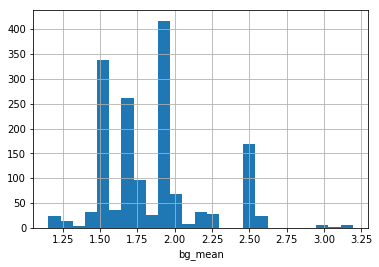

2    20000.00 22000.00 2917   0.984      3.572     


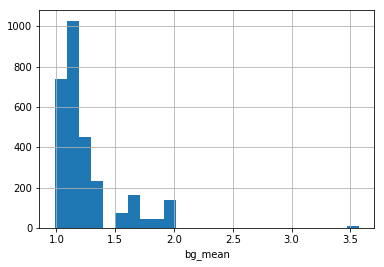

3    22000.00 24000.00 1522   0.906      13.411    


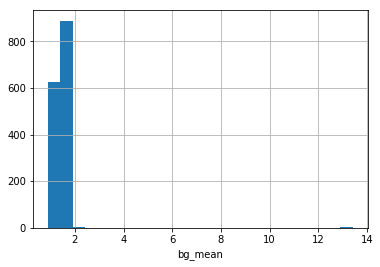

4    24000.00 26000.00 2866   1.089      2.239     


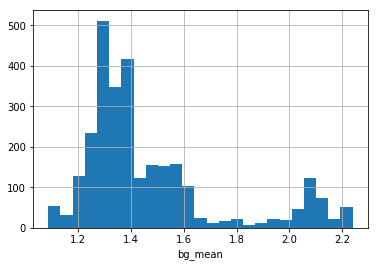

5    26000.00 28000.00 20664  0.963      6.879     


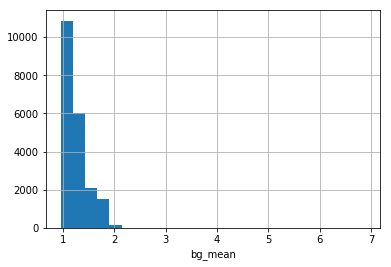

6    28000.00 30000.00 6178   0.933      5.128     


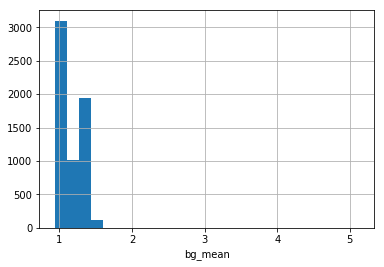

7    30000.00 32000.00 0      nan        nan       
8    32000.00 34000.00 0      nan        nan       
9    34000.00 36000.00 0      nan        nan       
10   36000.00 38000.00 0      nan        nan       


In [80]:
mean_gps_alt = []
mean_bg_mean_vals = []
median_bg_mean_vals = []
quantile_025_bg_mean_vals = []
quantile_975_bg_mean_vals = []
std_bg_mean_vals = []
count_bg_mean_vals = []

b_median_bg_mean_vals = []
b_quantile_025_bg_mean_vals = []
b_quantile_975_bg_mean_vals = []

filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
filtered_df = filtered_firstev_df

bins_offset = 16000
bin_width = 2000

for i in range(0,math.ceil((36000 - bins_offset)/bin_width)+1):
    min_v = bins_offset + i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[(min_v <= filtered_df.gps_alt_mean) & (filtered_df.gps_alt_mean < max_v)]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.bg_mean.min(), t_filtered_df.bg_mean.max()
    ))
    if len(t_filtered_df) > 0:
        h = t_filtered_df.bg_mean.hist(bins=25)
        h.set_xlabel('bg_mean')
        plt.show()
        
        mean_gps_alt.append(np.mean([min_v,max_v]))
        mean_bg_mean_vals.append(t_filtered_df.bg_mean.mean())
        median_bg_mean_vals.append(t_filtered_df.bg_mean.median())
        quantile_025_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.025))
        quantile_975_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.975))
        std_bg_mean_vals.append(t_filtered_df.bg_mean.std())
        count_bg_mean_vals.append(t_filtered_df.bg_mean.count())
        
        b_q025, b_m, b_q975 = bootstrap_quantiles(t_filtered_df, 'bg_mean')
        b_median_bg_mean_vals.append(b_m)
        b_quantile_025_bg_mean_vals.append(b_q025)
        b_quantile_975_bg_mean_vals.append(b_q975)
        
    
# filtered_df 

In [43]:
print('mean_gps_alt')
print(['{:.2f}'.format(v) for v in mean_gps_alt])
print('mean_bg_mean_vals')
print(['{:.2f}'.format(v) for v in mean_bg_mean_vals])
print('median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in median_bg_mean_vals])
print('quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_025_bg_mean_vals])
print('quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_975_bg_mean_vals])
print('std_bg_mean_vals')
print(['{:.2f}'.format(v) for v in std_bg_mean_vals])
print('count_bg_mean_vals')
print(['{:.2f}'.format(v) for v in count_bg_mean_vals])
print('b_median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_median_bg_mean_vals])
print('b_quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_quantile_025_bg_mean_vals])
print('b_quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in b_quantile_975_bg_mean_vals])

mean_gps_alt
['17000.00', '19000.00', '21000.00', '23000.00', '25000.00', '27000.00', '29000.00']
mean_bg_mean_vals
['1.39', '1.85', '1.24', '1.48', '1.47', '1.26', '1.17']
median_bg_mean_vals
['1.32', '1.78', '1.15', '1.46', '1.37', '1.19', '1.10']
quantile_025_bg_mean_vals
['1.21', '1.33', '0.99', '1.08', '1.16', '0.99', '0.96']
quantile_975_bg_mean_vals
['1.83', '2.54', '1.96', '1.88', '2.15', '1.84', '1.42']
std_bg_mean_vals
['0.18', '0.34', '0.28', '0.57', '0.27', '0.23', '0.17']
count_bg_mean_vals
['138.00', '1588.00', '2917.00', '1522.00', '2866.00', '20664.00', '6178.00']
b_median_bg_mean_vals
['1.39', '1.85', '1.24', '1.48', '1.47', '1.26', '1.17']
b_quantile_025_bg_mean_vals
['1.37', '1.82', '1.22', '1.44', '1.45', '1.24', '1.15']
b_quantile_975_bg_mean_vals
['1.40', '1.87', '1.27', '1.55', '1.49', '1.27', '1.18']


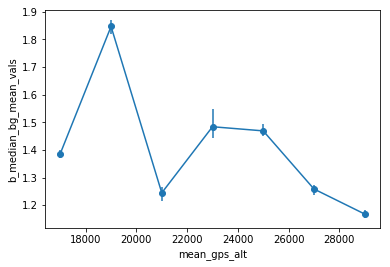

In [44]:
# probably incorrect
yerr=[np.array(b_median_bg_mean_vals) - np.array(b_quantile_025_bg_mean_vals), 
      np.array(b_quantile_975_bg_mean_vals) - np.array(b_median_bg_mean_vals)]
fig, ax = plt.subplots(1)
h = ax.errorbar(mean_gps_alt, b_median_bg_mean_vals, marker='o', yerr=yerr)
ax.set_xlabel('mean_gps_alt')
ax.set_ylabel('b_median_bg_mean_vals')
plt.show()

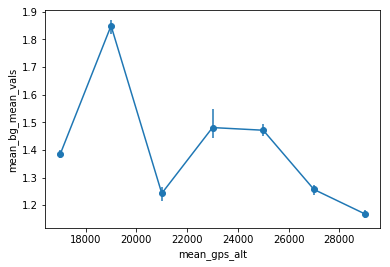

In [45]:
# probably incorrect
yerr=[np.array(mean_bg_mean_vals) - np.array(b_quantile_025_bg_mean_vals), 
      np.array(b_quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
fig, ax = plt.subplots(1)
ax.errorbar(mean_gps_alt, mean_bg_mean_vals, marker='o', yerr=yerr)
ax.set_xlabel('mean_gps_alt')
ax.set_ylabel('mean_bg_mean_vals')
plt.show()

In [46]:
print(mean_gps_alt)
print(mean_bg_mean_vals)
print(std_bg_mean_vals)
# plt.errorbar(mean_gps_alt, mean_bg_mean_vals, marker='o', yerr=std_bg_mean_vals)
# plt.show()

[17000.0, 19000.0, 21000.0, 23000.0, 25000.0, 27000.0, 29000.0]
[1.3856936231884058, 1.849622216624685, 1.2428354713746999, 1.4810179441524312, 1.4713722575017447, 1.2569548358981804, 1.1688052415021042]
[0.17780926920302526, 0.33757730285692666, 0.2778158125452298, 0.573660341925421, 0.26933291420424293, 0.23065782908229748, 0.17259524590907216]


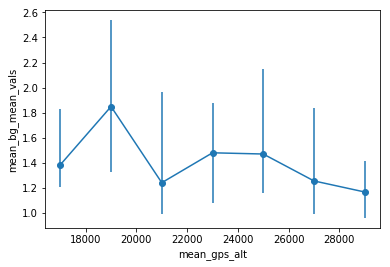

In [47]:
yerr=[np.array(mean_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
fig, ax = plt.subplots(1)
ax.errorbar(mean_gps_alt, mean_bg_mean_vals, marker='o', yerr=yerr)
ax.set_xlabel('mean_gps_alt')
ax.set_ylabel('mean_bg_mean_vals')
plt.show()

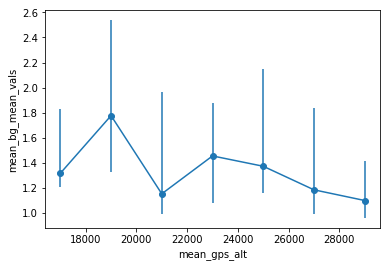

In [48]:
yerr=[np.array(median_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(median_bg_mean_vals)]
fig, ax = plt.subplots(1)
ax.errorbar(mean_gps_alt, median_bg_mean_vals, marker='o', yerr=yerr)
ax.set_xlabel('mean_gps_alt')
ax.set_ylabel('mean_bg_mean_vals')
plt.show()

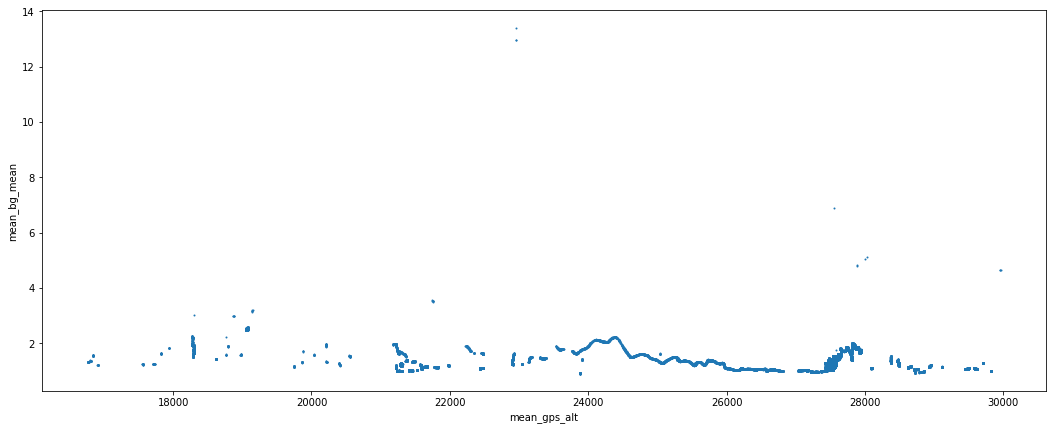

In [49]:
plt.close('all')
fig, ax = plt.subplots(1)
fig.set_size_inches(18,7)
filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
ax.scatter(x=filtered_firstev_df['gps_alt_mean'], y=filtered_firstev_df['bg_mean'],s=1)
# filtered_background_df.plot.scatter(x='gtu_datetime_min',y='bg_mean')
ax.set_xlabel('mean_gps_alt')
ax.set_ylabel('mean_bg_mean')
plt.show()

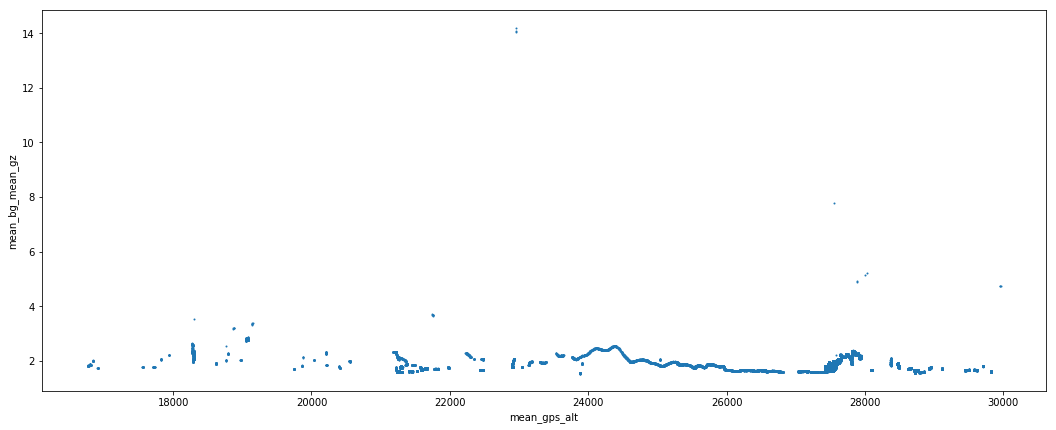

In [50]:
plt.close('all')
fig, ax = plt.subplots(1)
fig.set_size_inches(18,7)
filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
ax.scatter(x=filtered_firstev_df['gps_alt_mean'], y=filtered_firstev_df['bg_mean_gz'],s=1)
# filtered_background_df.plot.scatter(x='gtu_datetime_min',y='bg_mean')
ax.set_xlabel('mean_gps_alt')
ax.set_ylabel('mean_bg_mean_gz')
plt.show()

## Background - time relation

In [51]:
print(filtered_background_df.gtu_datetime_min.min())
print(filtered_background_df.gtu_datetime_min.min().timestamp())

2017-04-27 08:25:12.000200
1493274312.0002


In [52]:
print(len(filtered_background_df))

67618


0    1493274312.00 (2017-04-27 06:25:12.000200) 1493277912.00 (2017-04-27 07:25:12.000200) 0      nan        nan       
1    1493277912.00 (2017-04-27 07:25:12.000200) 1493281512.00 (2017-04-27 08:25:12.000200) 0      nan        nan       
2    1493281512.00 (2017-04-27 08:25:12.000200) 1493285112.00 (2017-04-27 09:25:12.000200) 2205   0.986      1.115     


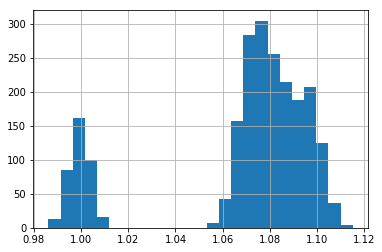

3    1493285112.00 (2017-04-27 09:25:12.000200) 1493288712.00 (2017-04-27 10:25:12.000200) 0      nan        nan       
4    1493288712.00 (2017-04-27 10:25:12.000200) 1493292312.00 (2017-04-27 11:25:12.000200) 212    1.085      1.112     


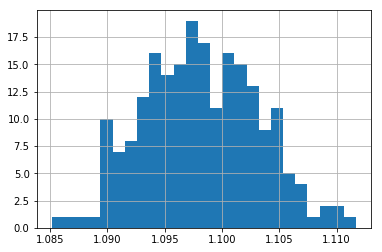

5    1493292312.00 (2017-04-27 11:25:12.000200) 1493295912.00 (2017-04-27 12:25:12.000200) 201    1.053      1.078     


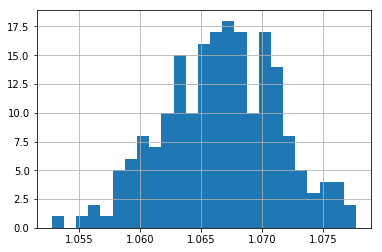

6    1493295912.00 (2017-04-27 12:25:12.000200) 1493299512.00 (2017-04-27 13:25:12.000200) 156    1.271      1.299     


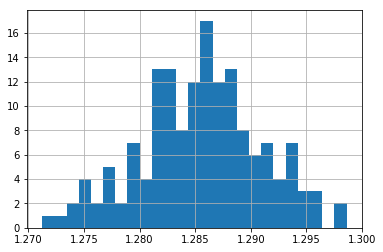

7    1493299512.00 (2017-04-27 13:25:12.000200) 1493303112.00 (2017-04-27 14:25:12.000200) 0      nan        nan       
8    1493303112.00 (2017-04-27 14:25:12.000200) 1493306712.00 (2017-04-27 15:25:12.000200) 0      nan        nan       
9    1493306712.00 (2017-04-27 15:25:12.000200) 1493310312.00 (2017-04-27 16:25:12.000200) 0      nan        nan       
10   1493310312.00 (2017-04-27 16:25:12.000200) 1493313912.00 (2017-04-27 17:25:12.000200) 0      nan        nan       
11   1493313912.00 (2017-04-27 17:25:12.000200) 1493317512.00 (2017-04-27 18:25:12.000200) 0      nan        nan       
12   1493317512.00 (2017-04-27 18:25:12.000200) 1493321112.00 (2017-04-27 19:25:12.000200) 0      nan        nan       
13   1493321112.00 (2017-04-27 19:25:12.000200) 1493324712.00 (2017-04-27 20:25:12.000200) 0      nan        nan       
14   1493324712.00 (2017-04-27 20:25:12.000200) 1493328312.00 (2017-04-27 21:25:12.000200) 0      nan        nan       
15   1493328312.00 (2017-04-27 21:25:12.

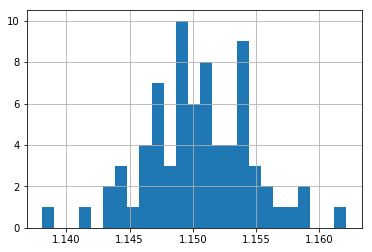

26   1493367912.00 (2017-04-28 08:25:12.000200) 1493371512.00 (2017-04-28 09:25:12.000200) 1265   0.933      1.300     


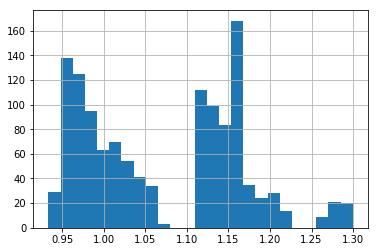

27   1493371512.00 (2017-04-28 09:25:12.000200) 1493375112.00 (2017-04-28 10:25:12.000200) 2061   1.175      1.548     


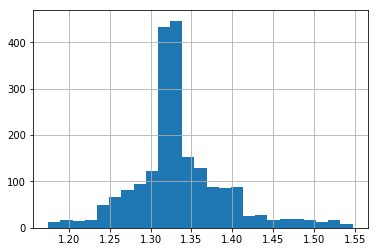

28   1493375112.00 (2017-04-28 10:25:12.000200) 1493378712.00 (2017-04-28 11:25:12.000200) 0      nan        nan       
29   1493378712.00 (2017-04-28 11:25:12.000200) 1493382312.00 (2017-04-28 12:25:12.000200) 608    1.641      1.873     


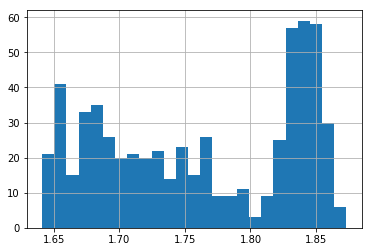

30   1493382312.00 (2017-04-28 12:25:12.000200) 1493385912.00 (2017-04-28 13:25:12.000200) 2547   1.236      2.012     


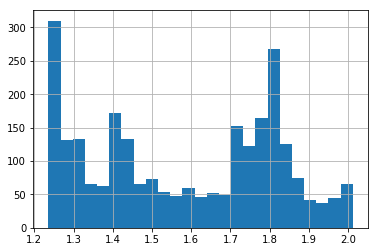

31   1493385912.00 (2017-04-28 13:25:12.000200) 1493389512.00 (2017-04-28 14:25:12.000200) 4628   1.042      1.631     


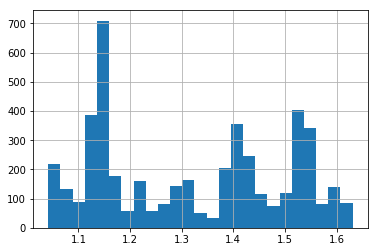

32   1493389512.00 (2017-04-28 14:25:12.000200) 1493393112.00 (2017-04-28 15:25:12.000200) 5097   1.027      1.241     


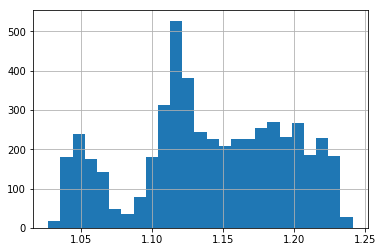

33   1493393112.00 (2017-04-28 15:25:12.000200) 1493396712.00 (2017-04-28 16:25:12.000200) 3000   1.052      6.879     


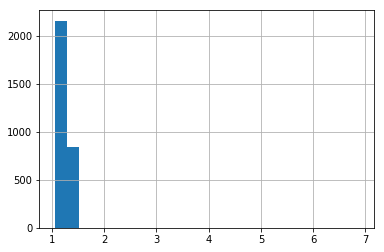

34   1493396712.00 (2017-04-28 16:25:12.000200) 1493400312.00 (2017-04-28 17:25:12.000200) 790    1.237      1.772     


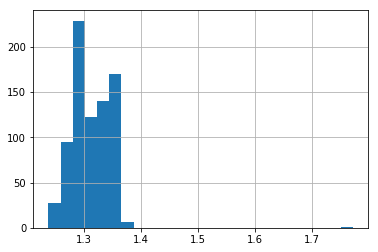

35   1493400312.00 (2017-04-28 17:25:12.000200) 1493403912.00 (2017-04-28 18:25:12.000200) 0      nan        nan       
36   1493403912.00 (2017-04-28 18:25:12.000200) 1493407512.00 (2017-04-28 19:25:12.000200) 0      nan        nan       
37   1493407512.00 (2017-04-28 19:25:12.000200) 1493411112.00 (2017-04-28 20:25:12.000200) 0      nan        nan       
38   1493411112.00 (2017-04-28 20:25:12.000200) 1493414712.00 (2017-04-28 21:25:12.000200) 0      nan        nan       
39   1493414712.00 (2017-04-28 21:25:12.000200) 1493418312.00 (2017-04-28 22:25:12.000200) 0      nan        nan       
40   1493418312.00 (2017-04-28 22:25:12.000200) 1493421912.00 (2017-04-28 23:25:12.000200) 0      nan        nan       
41   1493421912.00 (2017-04-28 23:25:12.000200) 1493425512.00 (2017-04-29 00:25:12.000200) 0      nan        nan       
42   1493425512.00 (2017-04-29 00:25:12.000200) 1493429112.00 (2017-04-29 01:25:12.000200) 0      nan        nan       
43   1493429112.00 (2017-04-29 01:25:12.

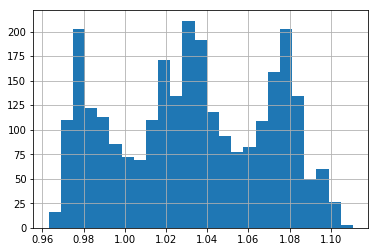

50   1493454312.00 (2017-04-29 08:25:12.000200) 1493457912.00 (2017-04-29 09:25:12.000200) 3732   0.986      1.902     


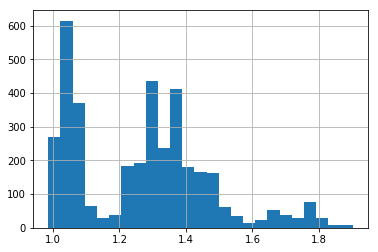

51   1493457912.00 (2017-04-29 09:25:12.000200) 1493461512.00 (2017-04-29 10:25:12.000200) 1327   1.117      2.239     


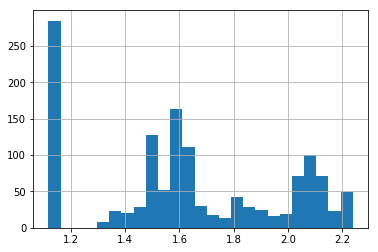

52   1493461512.00 (2017-04-29 10:25:12.000200) 1493465112.00 (2017-04-29 11:25:12.000200) 1047   1.080      1.980     


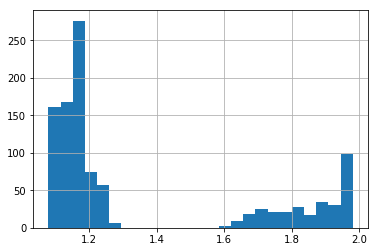

53   1493465112.00 (2017-04-29 11:25:12.000200) 1493468712.00 (2017-04-29 12:25:12.000200) 1029   0.984      1.727     


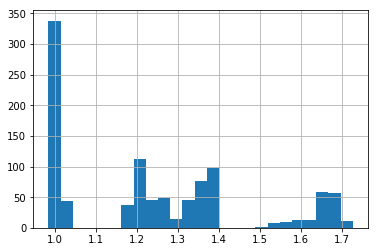

54   1493468712.00 (2017-04-29 12:25:12.000200) 1493472312.00 (2017-04-29 13:25:12.000200) 327    1.008      1.219     


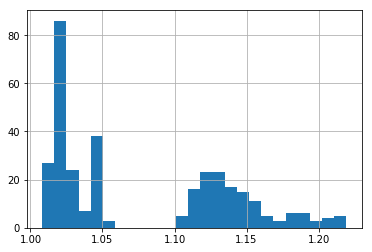

55   1493472312.00 (2017-04-29 13:25:12.000200) 1493475912.00 (2017-04-29 14:25:12.000200) 192    1.007      1.216     


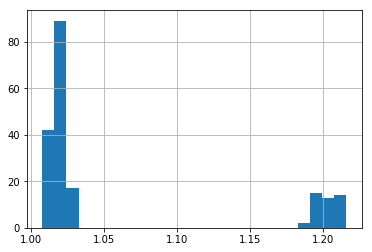

56   1493475912.00 (2017-04-29 14:25:12.000200) 1493479512.00 (2017-04-29 15:25:12.000200) 55     1.089      1.108     


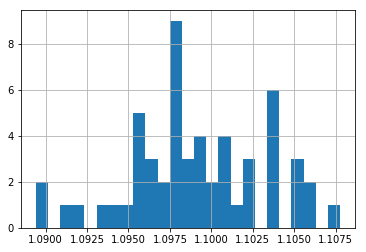

57   1493479512.00 (2017-04-29 15:25:12.000200) 1493483112.00 (2017-04-29 16:25:12.000200) 555    1.081      1.552     


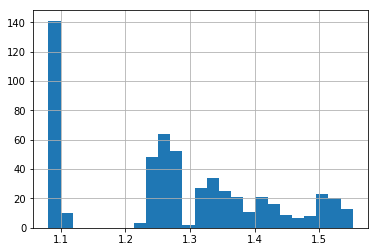

58   1493483112.00 (2017-04-29 16:25:12.000200) 1493486712.00 (2017-04-29 17:25:12.000200) 79     1.594      13.411    


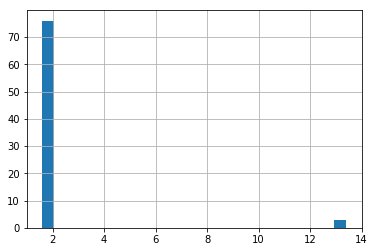

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
12.977935
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
59   1493486712.00 (2017-04-29 17:25:12.000200) 1493490312.00 (2017-04-29 18:25:12.000200) 0      nan        nan       
60   1493490312.00 (2017-04-29 18:25:12.000200) 1493493912.00 (2017-04-29 19:25:12.000200) 0      nan        nan       
61   1493493912.00 (2017-04-29 19:25:12.000200) 1493497512.00 (2017-04-29 20:25:12.000200) 0      nan        nan       
62   1493497512.00 (2017-04-29 20:25:12.000200) 1493501112.00 (2017-04-29 21:25:12.000200) 0      nan        nan       
63   1493501112.00 (2017-04-29 21:25:12.000200) 1493504712.00 (2017-04-29 22:25:12.000200) 0      nan        nan       
64   1493504712.00 (2017-04-29 22:25:12.000200) 1493508312.00 (2017-04-29 23:25:12.000200) 0      nan        nan       
65   1493508312.00 (2017-04-29 23:25:12.000200) 1493511912.00 (2017-04-30 00:25:12.000200) 0      nan        nan       
66   1493511912.00 (2017-04-30 00:25:12.000200) 1493515512.00 (2017-04-30 01:25:12.00020

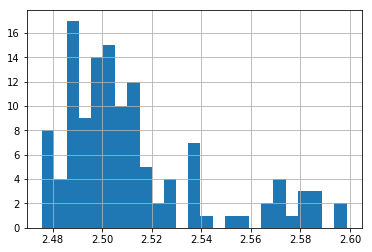

73   1493537112.00 (2017-04-30 07:25:12.000200) 1493540712.00 (2017-04-30 08:25:12.000200) 67     2.465      2.568     


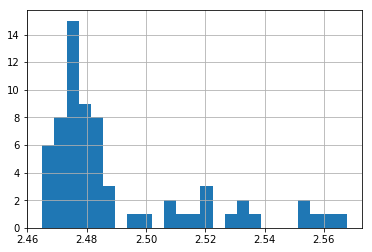

74   1493540712.00 (2017-04-30 08:25:12.000200) 1493544312.00 (2017-04-30 09:25:12.000200) 0      nan        nan       
75   1493544312.00 (2017-04-30 09:25:12.000200) 1493547912.00 (2017-04-30 10:25:12.000200) 18     1.539      1.585     


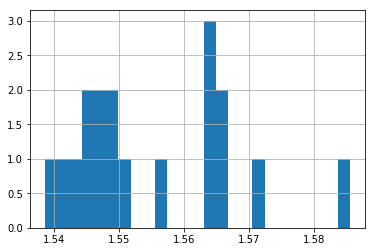

76   1493547912.00 (2017-04-30 10:25:12.000200) 1493551512.00 (2017-04-30 11:25:12.000200) 27     1.306      1.326     


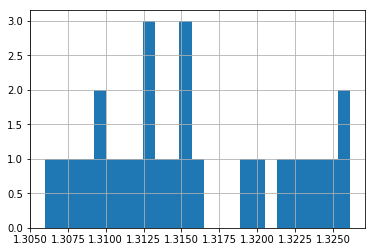

77   1493551512.00 (2017-04-30 11:25:12.000200) 1493555112.00 (2017-04-30 12:25:12.000200) 21     1.355      1.380     


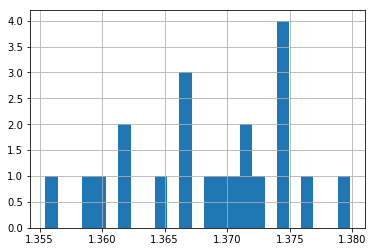

78   1493555112.00 (2017-04-30 12:25:12.000200) 1493558712.00 (2017-04-30 13:25:12.000200) 0      nan        nan       
79   1493558712.00 (2017-04-30 13:25:12.000200) 1493562312.00 (2017-04-30 14:25:12.000200) 14     1.204      1.216     


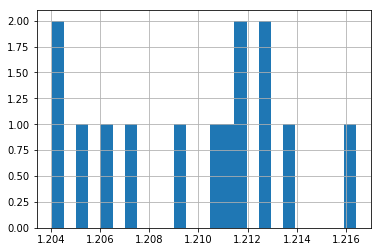

80   1493562312.00 (2017-04-30 14:25:12.000200) 1493565912.00 (2017-04-30 15:25:12.000200) 21     1.240      1.257     


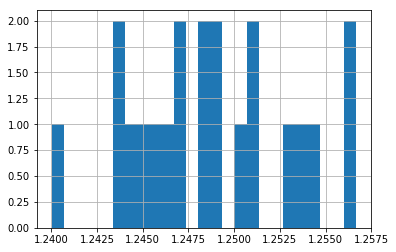

81   1493565912.00 (2017-04-30 15:25:12.000200) 1493569512.00 (2017-04-30 16:25:12.000200) 9      1.820      1.839     


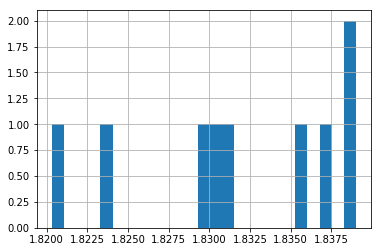

82   1493569512.00 (2017-04-30 16:25:12.000200) 1493573112.00 (2017-04-30 17:25:12.000200) 0      nan        nan       
83   1493573112.00 (2017-04-30 17:25:12.000200) 1493576712.00 (2017-04-30 18:25:12.000200) 0      nan        nan       
84   1493576712.00 (2017-04-30 18:25:12.000200) 1493580312.00 (2017-04-30 19:25:12.000200) 0      nan        nan       
85   1493580312.00 (2017-04-30 19:25:12.000200) 1493583912.00 (2017-04-30 20:25:12.000200) 0      nan        nan       
86   1493583912.00 (2017-04-30 20:25:12.000200) 1493587512.00 (2017-04-30 21:25:12.000200) 0      nan        nan       
87   1493587512.00 (2017-04-30 21:25:12.000200) 1493591112.00 (2017-04-30 22:25:12.000200) 0      nan        nan       
88   1493591112.00 (2017-04-30 22:25:12.000200) 1493594712.00 (2017-04-30 23:25:12.000200) 0      nan        nan       
89   1493594712.00 (2017-04-30 23:25:12.000200) 1493598312.00 (2017-05-01 00:25:12.000200) 0      nan        nan       
90   1493598312.00 (2017-05-01 00:25:12.

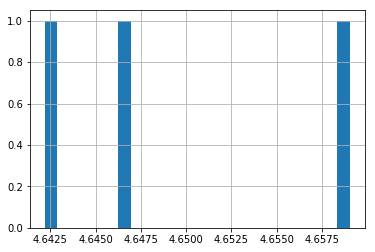

95   1493616312.00 (2017-05-01 05:25:12.000200) 1493619912.00 (2017-05-01 06:25:12.000200) 0      nan        nan       
96   1493619912.00 (2017-05-01 06:25:12.000200) 1493623512.00 (2017-05-01 07:25:12.000200) 4      4.810      5.128     


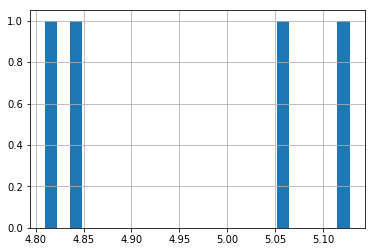

97   1493623512.00 (2017-05-01 07:25:12.000200) 1493627112.00 (2017-05-01 08:25:12.000200) 0      nan        nan       
98   1493627112.00 (2017-05-01 08:25:12.000200) 1493630712.00 (2017-05-01 09:25:12.000200) 0      nan        nan       
99   1493630712.00 (2017-05-01 09:25:12.000200) 1493634312.00 (2017-05-01 10:25:12.000200) 8      1.395      1.411     


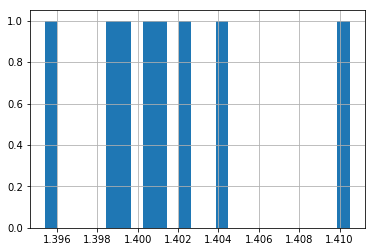

100  1493634312.00 (2017-05-01 10:25:12.000200) 1493637912.00 (2017-05-01 11:25:12.000200) 11     1.601      1.645     


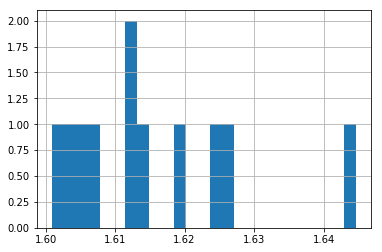

101  1493637912.00 (2017-05-01 11:25:12.000200) 1493641512.00 (2017-05-01 12:25:12.000200) 25     1.384      1.441     


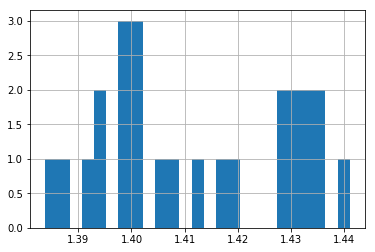

102  1493641512.00 (2017-05-01 12:25:12.000200) 1493645112.00 (2017-05-01 13:25:12.000200) 7      3.496      3.572     


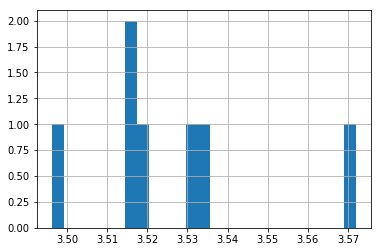

103  1493645112.00 (2017-05-01 13:25:12.000200) 1493648712.00 (2017-05-01 14:25:12.000200) 31     1.502      1.560     


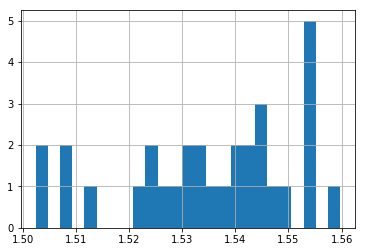

104  1493648712.00 (2017-05-01 14:25:12.000200) 1493652312.00 (2017-05-01 15:25:12.000200) 6      3.124      3.192     


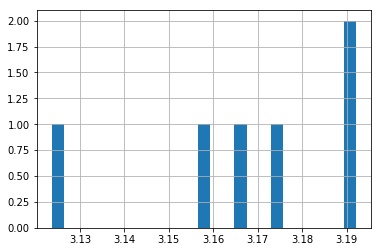

105  1493652312.00 (2017-05-01 15:25:12.000200) 1493655912.00 (2017-05-01 16:25:12.000200) 0      nan        nan       
106  1493655912.00 (2017-05-01 16:25:12.000200) 1493659512.00 (2017-05-01 17:25:12.000200) 0      nan        nan       
107  1493659512.00 (2017-05-01 17:25:12.000200) 1493663112.00 (2017-05-01 18:25:12.000200) 0      nan        nan       
108  1493663112.00 (2017-05-01 18:25:12.000200) 1493666712.00 (2017-05-01 19:25:12.000200) 0      nan        nan       
109  1493666712.00 (2017-05-01 19:25:12.000200) 1493670312.00 (2017-05-01 20:25:12.000200) 0      nan        nan       
110  1493670312.00 (2017-05-01 20:25:12.000200) 1493673912.00 (2017-05-01 21:25:12.000200) 0      nan        nan       
111  1493673912.00 (2017-05-01 21:25:12.000200) 1493677512.00 (2017-05-01 22:25:12.000200) 0      nan        nan       
112  1493677512.00 (2017-05-01 22:25:12.000200) 1493681112.00 (2017-05-01 23:25:12.000200) 0      nan        nan       
113  1493681112.00 (2017-05-01 23:25:12.

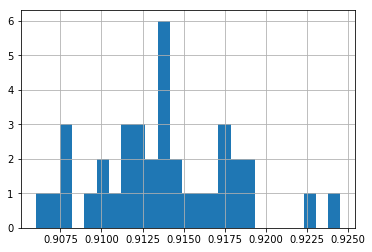

124  1493720712.00 (2017-05-02 10:25:12.000200) 1493724312.00 (2017-05-02 11:25:12.000200) 32     1.247      1.269     


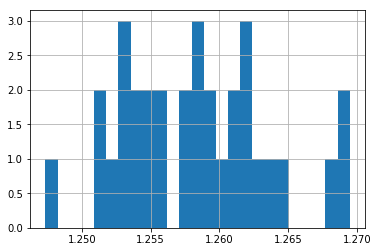

125  1493724312.00 (2017-05-02 11:25:12.000200) 1493727912.00 (2017-05-02 12:25:12.000200) 0      nan        nan       
126  1493727912.00 (2017-05-02 12:25:12.000200) 1493731512.00 (2017-05-02 13:25:12.000200) 26     1.883      1.973     


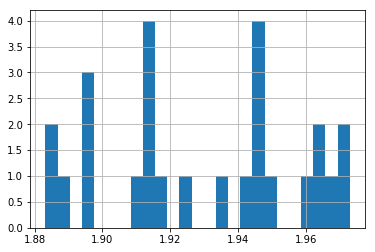

127  1493731512.00 (2017-05-02 13:25:12.000200) 1493735112.00 (2017-05-02 14:25:12.000200) 5      2.981      2.998     


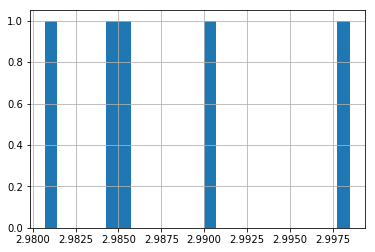

128  1493735112.00 (2017-05-02 14:25:12.000200) 1493738712.00 (2017-05-02 15:25:12.000200) 16     1.879      1.902     


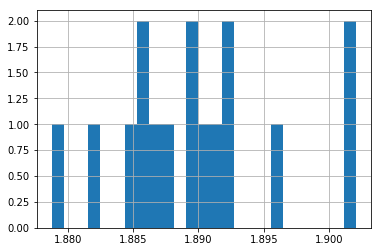

129  1493738712.00 (2017-05-02 15:25:12.000200) 1493742312.00 (2017-05-02 16:25:12.000200) 0      nan        nan       
130  1493742312.00 (2017-05-02 16:25:12.000200) 1493745912.00 (2017-05-02 17:25:12.000200) 0      nan        nan       
131  1493745912.00 (2017-05-02 17:25:12.000200) 1493749512.00 (2017-05-02 18:25:12.000200) 0      nan        nan       
132  1493749512.00 (2017-05-02 18:25:12.000200) 1493753112.00 (2017-05-02 19:25:12.000200) 0      nan        nan       
133  1493753112.00 (2017-05-02 19:25:12.000200) 1493756712.00 (2017-05-02 20:25:12.000200) 0      nan        nan       
134  1493756712.00 (2017-05-02 20:25:12.000200) 1493760312.00 (2017-05-02 21:25:12.000200) 0      nan        nan       
135  1493760312.00 (2017-05-02 21:25:12.000200) 1493763912.00 (2017-05-02 22:25:12.000200) 0      nan        nan       
136  1493763912.00 (2017-05-02 22:25:12.000200) 1493767512.00 (2017-05-02 23:25:12.000200) 0      nan        nan       
137  1493767512.00 (2017-05-02 23:25:12.

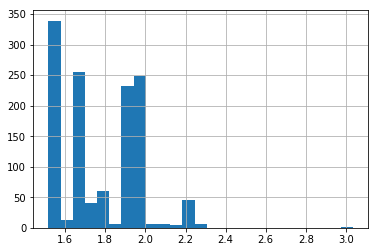

147  1493803512.00 (2017-05-03 09:25:12.000200) 1493807112.00 (2017-05-03 10:25:12.000200) 0      nan        nan       
148  1493807112.00 (2017-05-03 10:25:12.000200) 1493810712.00 (2017-05-03 11:25:12.000200) 32     1.416      1.438     


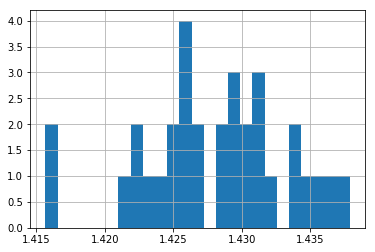

149  1493810712.00 (2017-05-03 11:25:12.000200) 1493814312.00 (2017-05-03 12:25:12.000200) 0      nan        nan       
150  1493814312.00 (2017-05-03 12:25:12.000200) 1493817912.00 (2017-05-03 13:25:12.000200) 17     1.588      1.601     


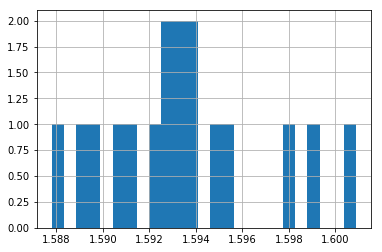

151  1493817912.00 (2017-05-03 13:25:12.000200) 1493821512.00 (2017-05-03 14:25:12.000200) 8      1.569      2.238     


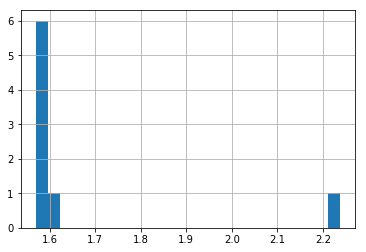

152  1493821512.00 (2017-05-03 14:25:12.000200) 1493825112.00 (2017-05-03 15:25:12.000200) 0      nan        nan       
153  1493825112.00 (2017-05-03 15:25:12.000200) 1493828712.00 (2017-05-03 16:25:12.000200) 0      nan        nan       
154  1493828712.00 (2017-05-03 16:25:12.000200) 1493832312.00 (2017-05-03 17:25:12.000200) 0      nan        nan       
155  1493832312.00 (2017-05-03 17:25:12.000200) 1493835912.00 (2017-05-03 18:25:12.000200) 0      nan        nan       
156  1493835912.00 (2017-05-03 18:25:12.000200) 1493839512.00 (2017-05-03 19:25:12.000200) 0      nan        nan       
157  1493839512.00 (2017-05-03 19:25:12.000200) 1493843112.00 (2017-05-03 20:25:12.000200) 0      nan        nan       
158  1493843112.00 (2017-05-03 20:25:12.000200) 1493846712.00 (2017-05-03 21:25:12.000200) 0      nan        nan       
159  1493846712.00 (2017-05-03 21:25:12.000200) 1493850312.00 (2017-05-03 22:25:12.000200) 0      nan        nan       
160  1493850312.00 (2017-05-03 22:25:12.

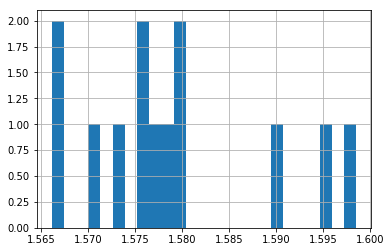

174  1493900712.00 (2017-05-04 12:25:12.000200) 1493904312.00 (2017-05-04 13:25:12.000200) 4      1.695      1.733     


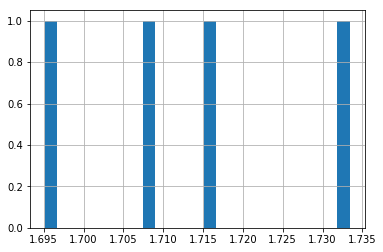

175  1493904312.00 (2017-05-04 13:25:12.000200) 1493907912.00 (2017-05-04 14:25:12.000200) 24     1.154      1.172     


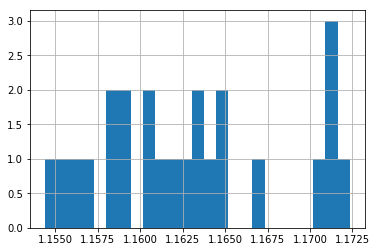

176  1493907912.00 (2017-05-04 14:25:12.000200) 1493911512.00 (2017-05-04 15:25:12.000200) 0      nan        nan       
177  1493911512.00 (2017-05-04 15:25:12.000200) 1493915112.00 (2017-05-04 16:25:12.000200) 0      nan        nan       
178  1493915112.00 (2017-05-04 16:25:12.000200) 1493918712.00 (2017-05-04 17:25:12.000200) 0      nan        nan       
179  1493918712.00 (2017-05-04 17:25:12.000200) 1493922312.00 (2017-05-04 18:25:12.000200) 0      nan        nan       
180  1493922312.00 (2017-05-04 18:25:12.000200) 1493925912.00 (2017-05-04 19:25:12.000200) 0      nan        nan       
181  1493925912.00 (2017-05-04 19:25:12.000200) 1493929512.00 (2017-05-04 20:25:12.000200) 0      nan        nan       
182  1493929512.00 (2017-05-04 20:25:12.000200) 1493933112.00 (2017-05-04 21:25:12.000200) 0      nan        nan       
183  1493933112.00 (2017-05-04 21:25:12.000200) 1493936712.00 (2017-05-04 22:25:12.000200) 0      nan        nan       
184  1493936712.00 (2017-05-04 22:25:12.

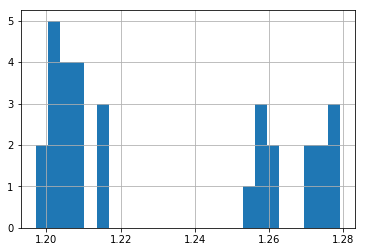

196  1493979912.00 (2017-05-05 10:25:12.000200) 1493983512.00 (2017-05-05 11:25:12.000200) 11     1.327      1.348     


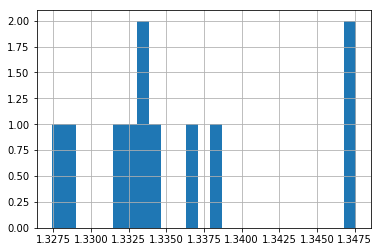

197  1493983512.00 (2017-05-05 11:25:12.000200) 1493987112.00 (2017-05-05 12:25:12.000200) 17     1.305      1.330     


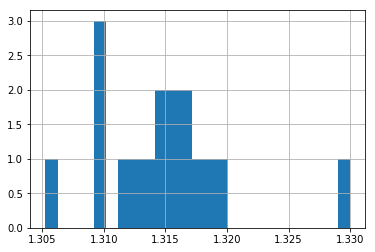

198  1493987112.00 (2017-05-05 12:25:12.000200) 1493990712.00 (2017-05-05 13:25:12.000200) 0      nan        nan       
199  1493990712.00 (2017-05-05 13:25:12.000200) 1493994312.00 (2017-05-05 14:25:12.000200) 0      nan        nan       
200  1493994312.00 (2017-05-05 14:25:12.000200) 1493997912.00 (2017-05-05 15:25:12.000200) 0      nan        nan       
201  1493997912.00 (2017-05-05 15:25:12.000200) 1494001512.00 (2017-05-05 16:25:12.000200) 0      nan        nan       
202  1494001512.00 (2017-05-05 16:25:12.000200) 1494005112.00 (2017-05-05 17:25:12.000200) 0      nan        nan       
203  1494005112.00 (2017-05-05 17:25:12.000200) 1494008712.00 (2017-05-05 18:25:12.000200) 0      nan        nan       
204  1494008712.00 (2017-05-05 18:25:12.000200) 1494012312.00 (2017-05-05 19:25:12.000200) 0      nan        nan       
205  1494012312.00 (2017-05-05 19:25:12.000200) 1494015912.00 (2017-05-05 20:25:12.000200) 0      nan        nan       
206  1494015912.00 (2017-05-05 20:25:12.

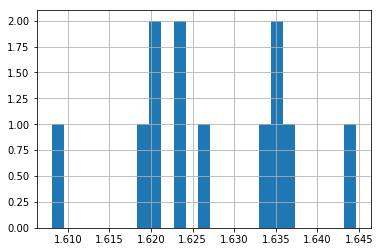

In [53]:
filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
filtered_df = filtered_firstev_df

bins_offset = filtered_df.gtu_datetime_min.min().timestamp()
bins_range_end = filtered_df.gtu_datetime_min.max().timestamp()
bin_width = 3600*1

mean_gtu_datetime_vals = []
mean_bg_mean_vals = []
median_bg_mean_vals = []
quantile_025_bg_mean_vals = []
quantile_975_bg_mean_vals = []
std_bg_mean_vals = []
count_bg_mean_vals = []


for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
    min_v = bins_offset + i*bin_width
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[
        (datetime.datetime.utcfromtimestamp(min_v) <= filtered_df.gtu_datetime_min) \
        & (filtered_df.gtu_datetime_min < datetime.datetime.utcfromtimestamp(max_v))]
    print("{:<4d} {:<5.2f} ({}) {:<5.2f} ({}) {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, datetime.datetime.utcfromtimestamp(min_v), max_v, datetime.datetime.utcfromtimestamp(max_v),
        len(t_filtered_df), t_filtered_df.bg_mean.min(), t_filtered_df.bg_mean.max()
    ))
    if len(t_filtered_df) > 0:
        t_filtered_df.bg_mean.hist(bins=25)
        plt.show()
        
        mean_gtu_datetime_vals.append(datetime.datetime.utcfromtimestamp(np.mean([min_v,max_v])))
        mean_bg_mean_vals.append(t_filtered_df.bg_mean.mean())
        median_bg_mean_vals.append(t_filtered_df.bg_mean.median())
        quantile_025_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.025))
        quantile_975_bg_mean_vals.append(t_filtered_df.bg_mean.quantile(0.975))
        if quantile_975_bg_mean_vals[-1] > 8:
            print('!'*30)
            print(quantile_975_bg_mean_vals[-1])
            print('!'*30)
        std_bg_mean_vals.append(t_filtered_df.bg_mean.std())
        count_bg_mean_vals.append(t_filtered_df.bg_mean.count())
                
    
# filtered_df 

In [54]:
print('mean_gtu_datetime_vals')
print([v.isoformat() for v in mean_gtu_datetime_vals])
print('mean_bg_mean_vals')
print(['{:.2f}'.format(v) for v in mean_bg_mean_vals])
print('median_bg_mean_vals')
print(['{:.2f}'.format(v) for v in median_bg_mean_vals])
print('quantile_025_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_025_bg_mean_vals])
print('quantile_975_bg_mean_vals')
print(['{:.2f}'.format(v) for v in quantile_975_bg_mean_vals])
print('std_bg_mean_vals')
print(['{:.2f}'.format(v) for v in std_bg_mean_vals])
print('count_bg_mean_vals')
print(['{:.2f}'.format(v) for v in count_bg_mean_vals])

mean_gtu_datetime_vals
['2017-04-27T08:55:12.000200', '2017-04-27T10:55:12.000200', '2017-04-27T11:55:12.000200', '2017-04-27T12:55:12.000200', '2017-04-28T07:55:12.000200', '2017-04-28T08:55:12.000200', '2017-04-28T09:55:12.000200', '2017-04-28T11:55:12.000200', '2017-04-28T12:55:12.000200', '2017-04-28T13:55:12.000200', '2017-04-28T14:55:12.000200', '2017-04-28T15:55:12.000200', '2017-04-28T16:55:12.000200', '2017-04-29T07:55:12.000200', '2017-04-29T08:55:12.000200', '2017-04-29T09:55:12.000200', '2017-04-29T10:55:12.000200', '2017-04-29T11:55:12.000200', '2017-04-29T12:55:12.000200', '2017-04-29T13:55:12.000200', '2017-04-29T14:55:12.000200', '2017-04-29T15:55:12.000200', '2017-04-29T16:55:12.000200', '2017-04-30T06:55:12.000200', '2017-04-30T07:55:12.000200', '2017-04-30T09:55:12.000200', '2017-04-30T10:55:12.000200', '2017-04-30T11:55:12.000200', '2017-04-30T13:55:12.000200', '2017-04-30T14:55:12.000200', '2017-04-30T15:55:12.000200', '2017-05-01T04:55:12.000200', '2017-05-01T06:5

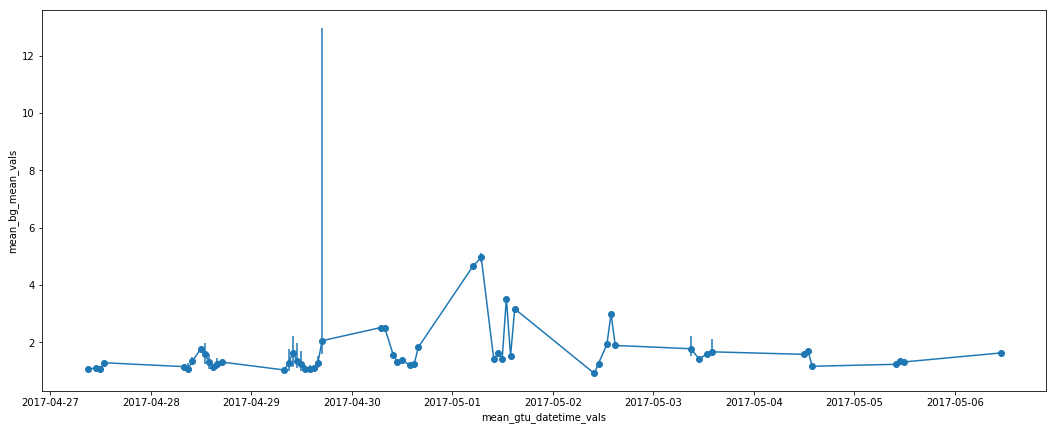

In [55]:
yerr=[np.array(mean_bg_mean_vals) - np.array(quantile_025_bg_mean_vals), 
      np.array(quantile_975_bg_mean_vals) - np.array(mean_bg_mean_vals)]
fig, ax = plt.subplots(1)
fig.set_size_inches(18,7)
ax.errorbar(mean_gtu_datetime_vals, mean_bg_mean_vals, marker='o', yerr=yerr)
ax.set_xlabel('mean_gtu_datetime_vals')
ax.set_ylabel('mean_bg_mean_vals')
plt.show()

### filtered data

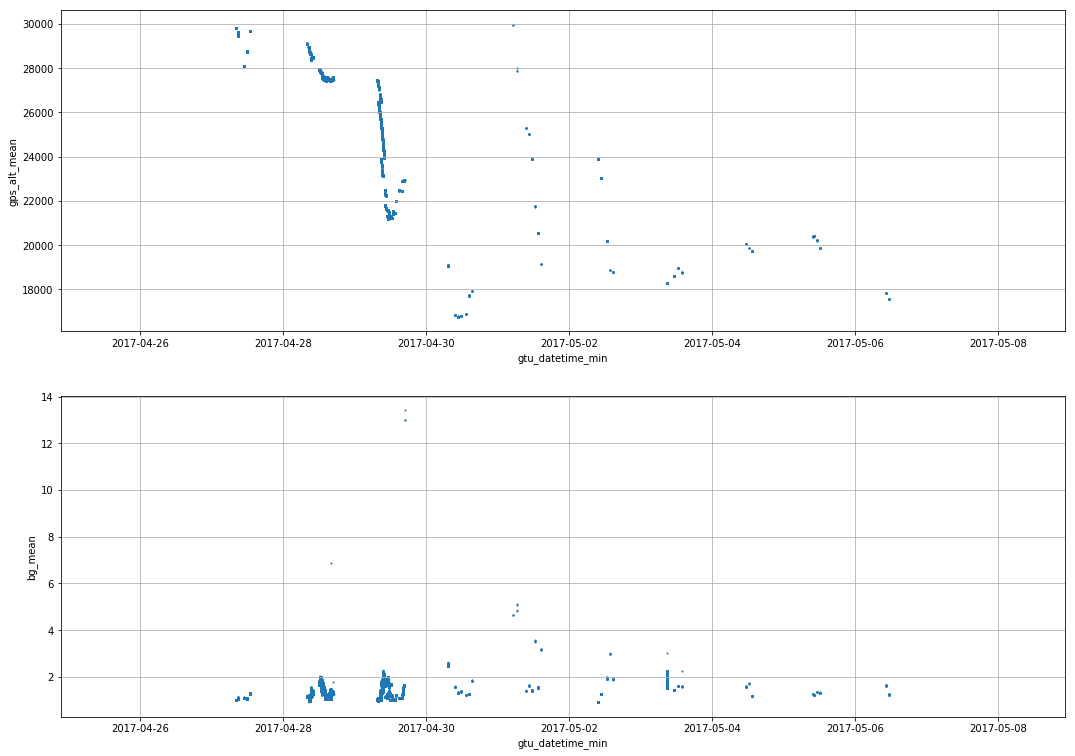

In [87]:
plt.close('all')
fig, (ax, ax2) = plt.subplots(2,1)
fig.set_size_inches(18,13)
filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
ax2.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['bg_mean'],s=1)
ax2.set_xlabel('gtu_datetime_min')
ax2.set_ylabel('bg_mean')
ax2.grid(True)
ax.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['gps_alt_mean'],s=1)
ax.set_xlabel('gtu_datetime_min')
ax.set_ylabel('gps_alt_mean')
ax.grid(True)
plt.show()

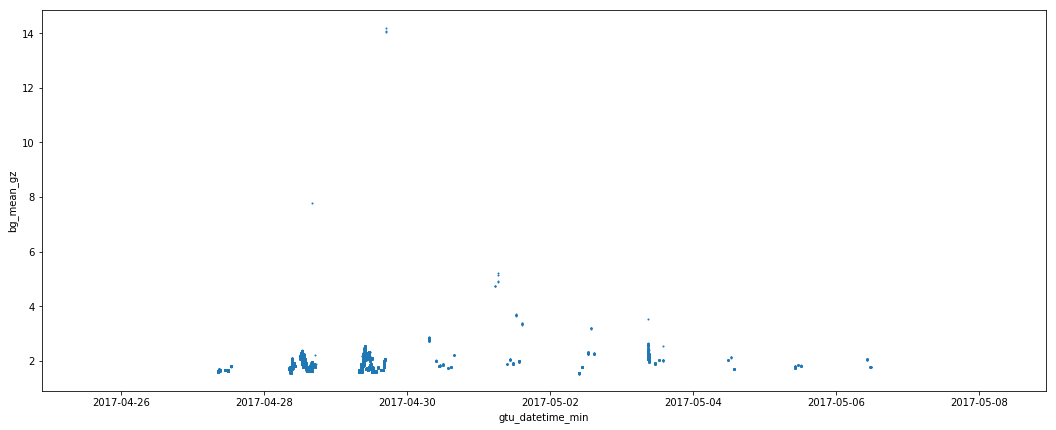

In [57]:
plt.close('all')
fig, ax = plt.subplots(1)
fig.set_size_inches(18,7)
filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
ax.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['bg_mean_gz'],s=1)
ax.set_xlabel('gtu_datetime_min')
ax.set_ylabel('bg_mean_gz')
plt.show()

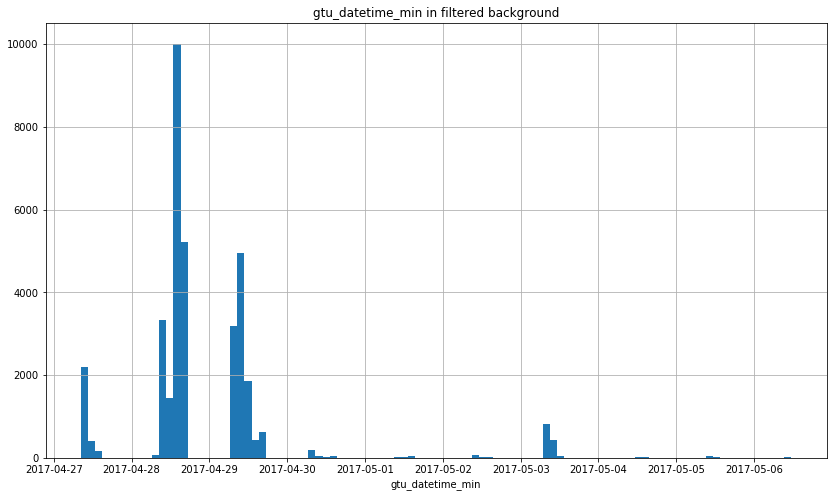

In [58]:
filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
h = filtered_firstev_df.gtu_datetime_min.hist(bins=100,figsize=(14,8))
h.set_title('gtu_datetime_min in filtered background')
h.set_xlabel('gtu_datetime_min')
plt.show()

### all flight data

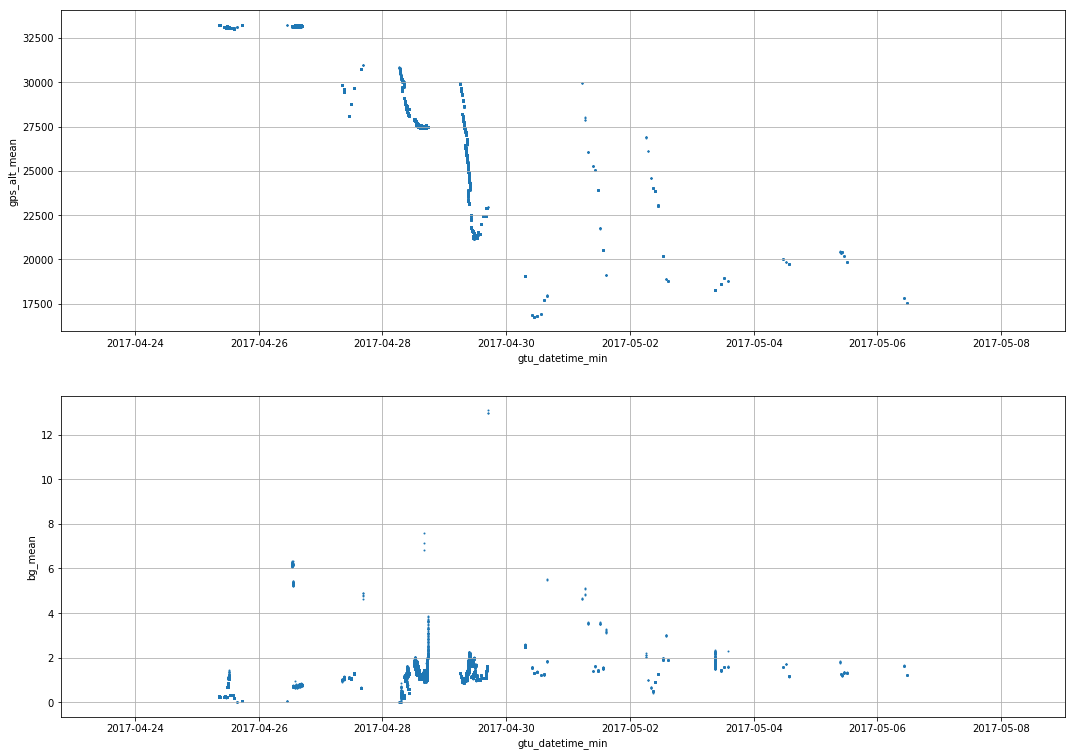

In [88]:
# plt.close('all')
# fig, ax = plt.subplots(1)
# fig.set_size_inches(18,7)
# filtered_firstev_df = flight_data_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
# ax.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['bg_mean'],s=2)
# ax.set_xlabel('gtu_datetime_min')
# ax.set_ylabel('bg_mean')
# plt.show()

plt.close('all')
fig, (ax, ax2) = plt.subplots(2,1)
fig.set_size_inches(18,13)
filtered_firstev_df = flight_data_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
ax2.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['bg_mean'],s=1)
ax2.set_xlabel('gtu_datetime_min')
ax2.set_ylabel('bg_mean')
ax2.grid(True)
ax.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['gps_alt_mean'],s=1)
ax.set_xlabel('gtu_datetime_min')
ax.set_ylabel('gps_alt_mean')
ax.grid(True)
plt.show()

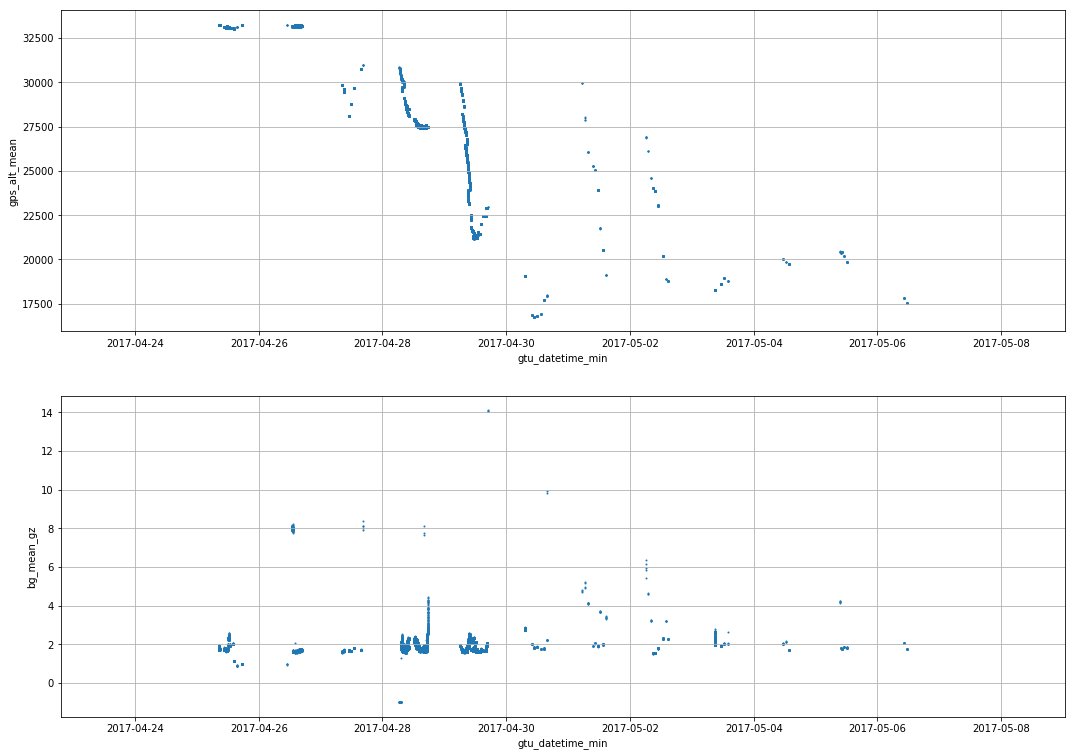

In [89]:
# plt.close('all')
# fig, ax = plt.subplots(1)
# fig.set_size_inches(18,7)
# filtered_firstev_df = flight_data_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
# ax.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['bg_mean_gz'],s=2)
# ax.set_xlabel('gtu_datetime_min')
# ax.set_ylabel('bg_mean_gz')
# plt.show()

plt.close('all')
fig, (ax, ax2) = plt.subplots(2,1)
fig.set_size_inches(18,13)
filtered_firstev_df = flight_data_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
ax2.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['bg_mean_gz'],s=1)
ax2.set_xlabel('gtu_datetime_min')
ax2.set_ylabel('bg_mean_gz')
ax2.grid(True)
ax.scatter(x=[d.to_pydatetime() for d in filtered_firstev_df['gtu_datetime_min']], y=filtered_firstev_df['gps_alt_mean'],s=1)
ax.set_xlabel('gtu_datetime_min')
ax.set_ylabel('gps_alt_mean')
ax.grid(True)
plt.show()

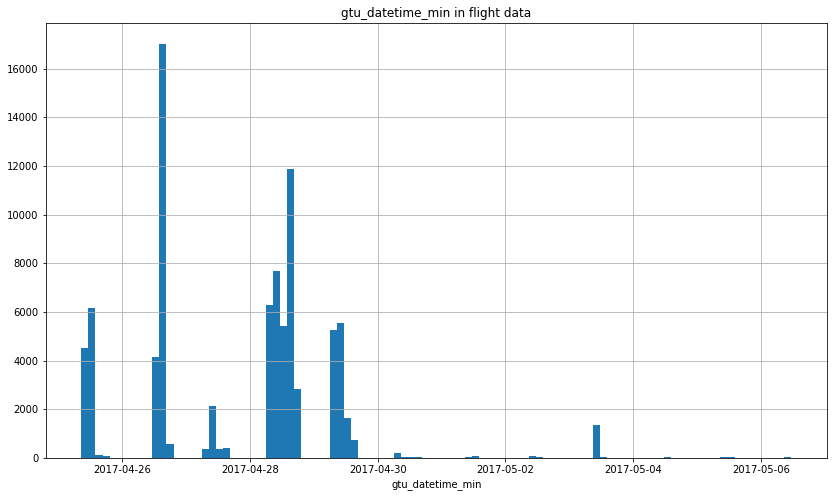

In [61]:
filtered_firstev_df = flight_data_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
h = filtered_firstev_df.gtu_datetime_min.hist(bins=100,figsize=(14,8))
h.set_title('gtu_datetime_min in flight data')
h.set_xlabel('gtu_datetime_min')
plt.show()

In [62]:
filtered_firstev_df = flight_data_df.groupby(['source_file_acquisition_full', 'packet_id']).first()
filtered_firstev_df.query('bg_mean_gz < 0')

event_id  \
source_file_acquisition_full                       packet_id             
/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO... 0                 1   
                                                   1                 3   
                                                   2                 4   
                                                   3                 5   
                                                   4                 6   
                                                   5                 7   
                                                   6                 8   
/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO... 0                 9   
                                                   1                11   
                                                   2                12   
                                                   3                13   
                                                   4                14   
                                                   5                15   
                                                   6                17   
                                                   7                19   
/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO... 0                21   
                                                   1                23   
                                                   2                24   
                                                   3                25   
                                                   4                26   
                                                   5                28   
                                                   6                30   
/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO... 0                31   
                                                   1                35   
                                                   2                37   
                                                   3                38   
                                                   4                40   
                                                   5                44   
                                                   6                45   
                                                   7                47   
...                                                                ...   
/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO... 2                53   
                                                   3                55   
                                                   4                56   
                                                   5                58   
                                                   6                66   
                                                   7                71   
/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO... 0                74   
                                                   1                76   
                                                   2                80   
                                                   4                83   
                                                   5                91   
                                                   6                98   
/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO... 0               105   
                                                   1               114   
                                                   2               130   
                                                   3               145   
                                                   4               158   
                                                   5               175   
                                                   6               186   
                                                   7               201   
/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO... 0               212   
                                                   1              

## Background - x_y_count_nonzero relation

### bg_mean

0    0.00  0.20  0      nan        nan       
1    0.20  0.40  0      nan        nan       
2    0.40  0.60  0      nan        nan       
3    0.60  0.80  0      nan        nan       
4    0.80  1.00  1554   2290.000   2291.000  


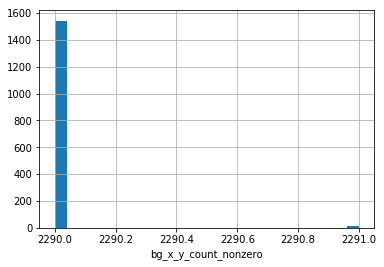

5    1.00  1.20  15453  2290.000   2291.000  


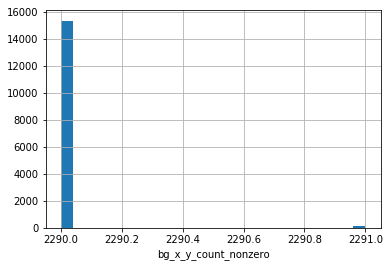

6    1.20  1.40  9762   2167.000   2291.000  


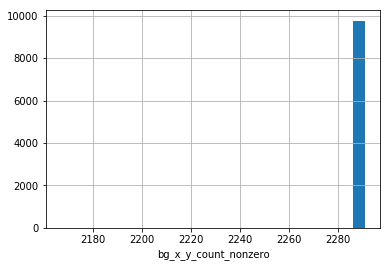

7    1.40  1.60  4409   2288.000   2291.000  


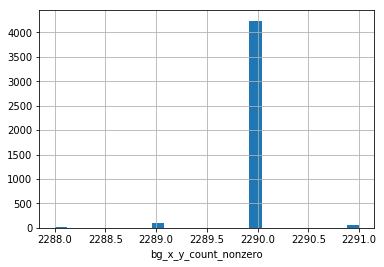

8    1.60  1.80  2309   2290.000   2291.000  


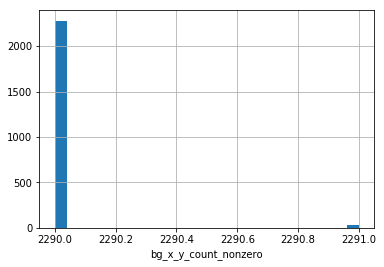

9    1.80  2.00  1754   2290.000   2291.000  


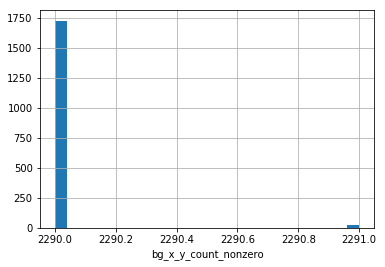

10   2.00  2.20  329    2290.000   2291.000  


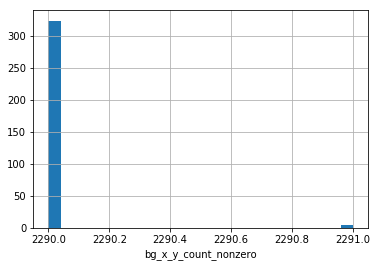

11   2.20  2.40  80     2290.000   2290.000  


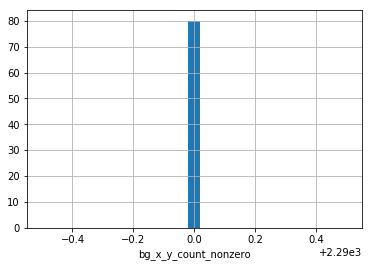

12   2.40  2.60  192    2290.000   2291.000  


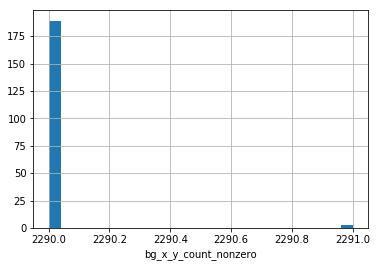

13   2.60  2.80  0      nan        nan       
14   2.80  3.00  5      2290.000   2290.000  


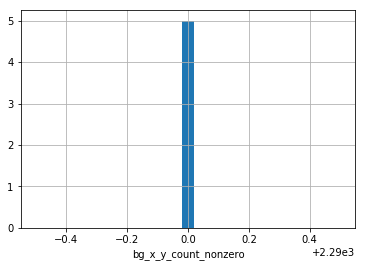

15   3.00  3.20  7      2290.000   2290.000  


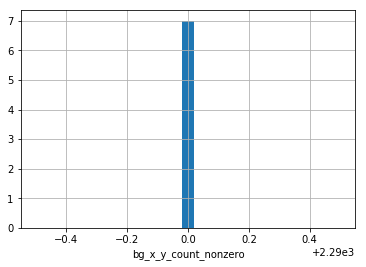

16   3.20  3.40  0      nan        nan       
17   3.40  3.60  7      2290.000   2291.000  


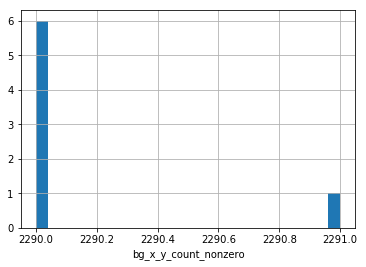

18   3.60  3.80  0      nan        nan       
19   3.80  4.00  0      nan        nan       
20   4.00  4.20  0      nan        nan       
21   4.20  4.40  0      nan        nan       
22   4.40  4.60  0      nan        nan       
23   4.60  4.80  3      2290.000   2290.000  


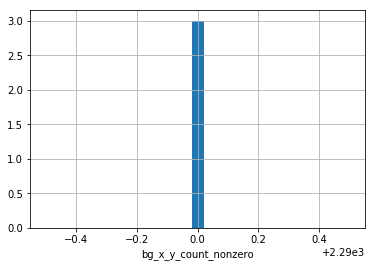

24   4.80  5.00  2      2290.000   2290.000  


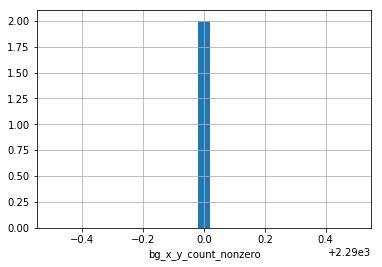

25   5.00  5.20  2      2290.000   2290.000  


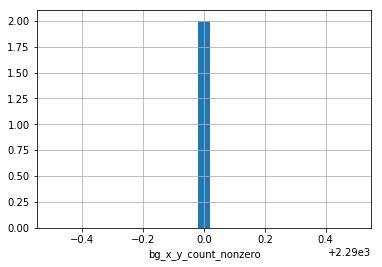

26   5.20  5.40  0      nan        nan       
27   5.40  5.60  0      nan        nan       
28   5.60  5.80  0      nan        nan       
29   5.80  6.00  0      nan        nan       
30   6.00  6.20  0      nan        nan       
31   6.20  6.40  0      nan        nan       
32   6.40  6.60  0      nan        nan       
33   6.60  6.80  0      nan        nan       
34   6.80  7.00  1      2148.000   2148.000  


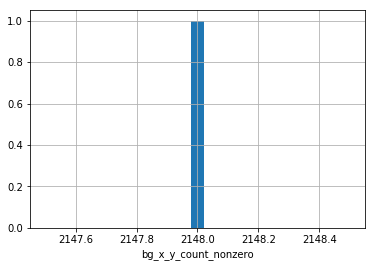

35   7.00  7.20  0      nan        nan       
36   7.20  7.40  0      nan        nan       
37   7.40  7.60  0      nan        nan       
38   7.60  7.80  0      nan        nan       
39   7.80  8.00  0      nan        nan       
40   8.00  8.20  0      nan        nan       
41   8.20  8.40  0      nan        nan       
42   8.40  8.60  0      nan        nan       
43   8.60  8.80  0      nan        nan       
44   8.80  9.00  0      nan        nan       
45   9.00  9.20  0      nan        nan       
46   9.20  9.40  0      nan        nan       
47   9.40  9.60  0      nan        nan       
48   9.60  9.80  0      nan        nan       
49   9.80  10.00 0      nan        nan       
50   10.00 10.20 0      nan        nan       
51   10.20 10.40 0      nan        nan       
52   10.40 10.60 0      nan        nan       
53   10.60 10.80 0      nan        nan       
54   10.80 11.00 0      nan        nan       
55   11.00 11.20 0      nan        nan       
56   11.20 11.40 0      nan       

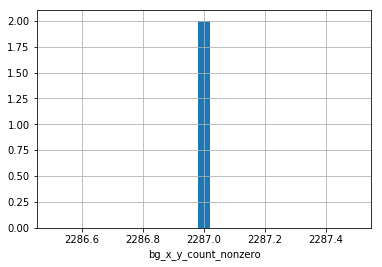

65   13.00 13.20 0      nan        nan       
66   13.20 13.40 0      nan        nan       
67   13.40 13.60 1      2290.000   2290.000  


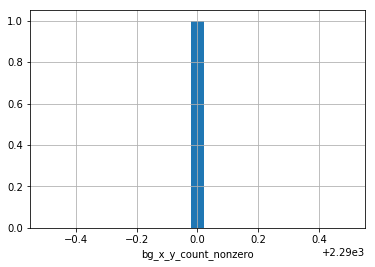

68   13.60 13.80 0      nan        nan       


In [63]:
mean_bg_mean = []
mean_bg_x_y_count_nonzero_vals = []
median_bg_x_y_count_nonzero_vals = []
quantile_025_bg_x_y_count_nonzero_vals = []
quantile_975_bg_x_y_count_nonzero_vals = []
std_bg_x_y_count_nonzero_vals = []
count_bg_x_y_count_nonzero_vals = []

filtered_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()

bins_offset = 0 #filtered_df.bg_mean.min()
bins_range_end = filtered_df.bg_mean.max()
bin_width = 0.20

for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
    min_v = i*bin_width + bins_offset
    max_v = min_v + bin_width
    t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean) & (filtered_df.bg_mean < max_v)]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.bg_x_y_count_nonzero.min(), t_filtered_df.bg_x_y_count_nonzero.max()
    ))
    if len(t_filtered_df) > 0:
        h = t_filtered_df.bg_x_y_count_nonzero.hist(bins=25)
        h.set_xlabel('bg_x_y_count_nonzero')
        plt.show()
        
        mean_bg_mean.append(np.mean([min_v,max_v]))
        mean_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.mean())
        median_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.median())
        quantile_025_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.quantile(0.025))
        quantile_975_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.quantile(0.975))
        std_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.std())
        count_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.count())
    
# filtered_df 

### bg_mean_gz

0    0.00  0.20  0      nan        nan       
1    0.20  0.40  0      nan        nan       
2    0.40  0.60  0      nan        nan       
3    0.60  0.80  0      nan        nan       
4    0.80  1.00  0      nan        nan       
5    1.00  1.20  0      nan        nan       
6    1.20  1.40  0      nan        nan       
7    1.40  1.60  843    2290.000   2291.000  


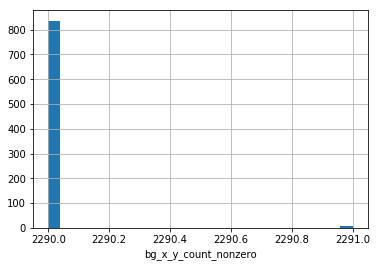

8    1.60  1.80  19097  2290.000   2291.000  


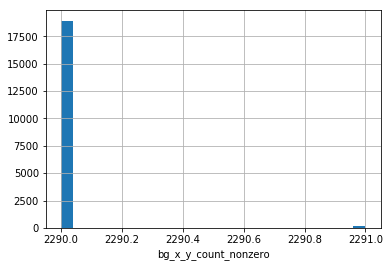

9    1.80  2.00  9979   2167.000   2291.000  


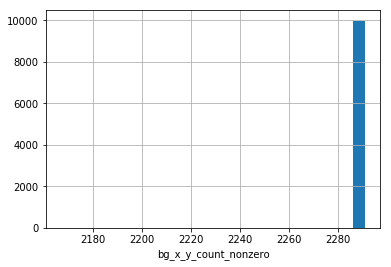

10   2.00  2.20  3276   2289.000   2291.000  


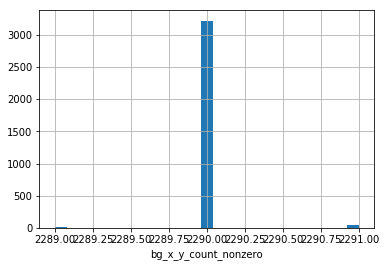

11   2.20  2.40  2114   2290.000   2291.000  


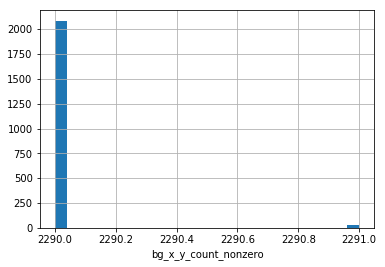

12   2.40  2.60  316    2290.000   2291.000  


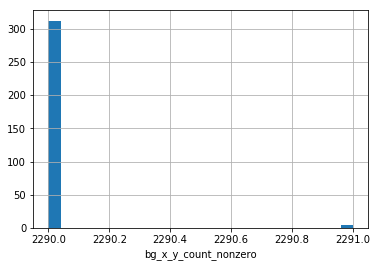

13   2.60  2.80  180    2290.000   2291.000  


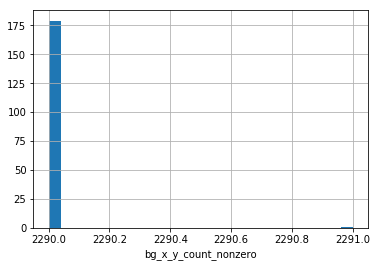

14   2.80  3.00  38     2290.000   2291.000  


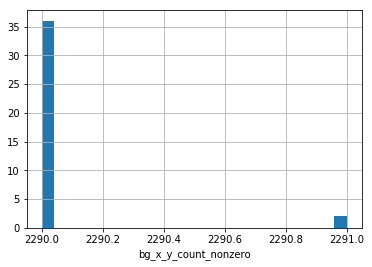

15   3.00  3.20  4      2290.000   2290.000  


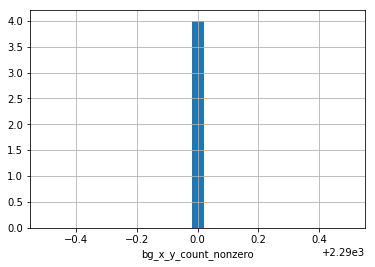

16   3.20  3.40  7      2290.000   2290.000  


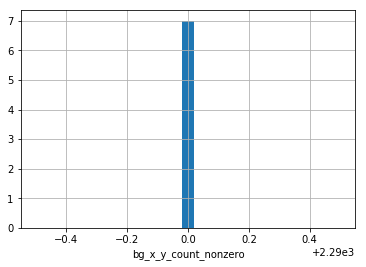

17   3.40  3.60  1      2290.000   2290.000  


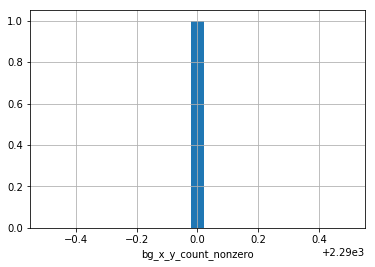

18   3.60  3.80  7      2290.000   2291.000  


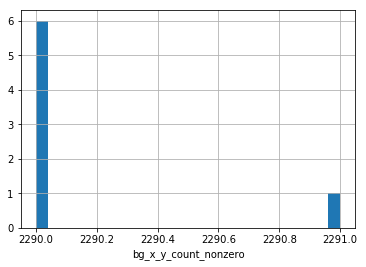

19   3.80  4.00  0      nan        nan       
20   4.00  4.20  0      nan        nan       
21   4.20  4.40  0      nan        nan       
22   4.40  4.60  0      nan        nan       
23   4.60  4.80  3      2290.000   2290.000  


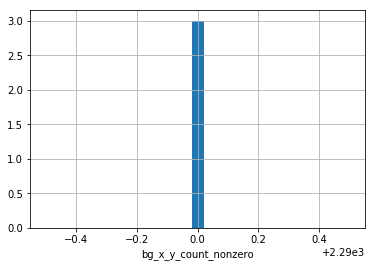

24   4.80  5.00  2      2290.000   2290.000  


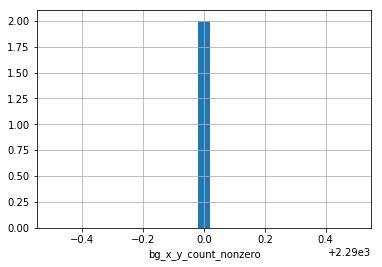

25   5.00  5.20  1      2290.000   2290.000  


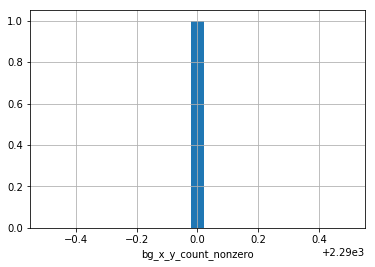

26   5.20  5.40  1      2290.000   2290.000  


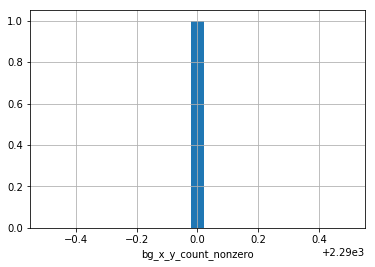

27   5.40  5.60  0      nan        nan       
28   5.60  5.80  0      nan        nan       
29   5.80  6.00  0      nan        nan       
30   6.00  6.20  0      nan        nan       
31   6.20  6.40  0      nan        nan       
32   6.40  6.60  0      nan        nan       
33   6.60  6.80  0      nan        nan       
34   6.80  7.00  0      nan        nan       
35   7.00  7.20  0      nan        nan       
36   7.20  7.40  0      nan        nan       
37   7.40  7.60  0      nan        nan       
38   7.60  7.80  1      2148.000   2148.000  


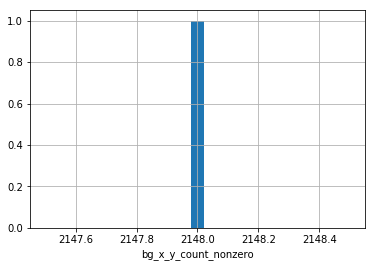

39   7.80  8.00  0      nan        nan       
40   8.00  8.20  0      nan        nan       
41   8.20  8.40  0      nan        nan       
42   8.40  8.60  0      nan        nan       
43   8.60  8.80  0      nan        nan       
44   8.80  9.00  0      nan        nan       
45   9.00  9.20  0      nan        nan       
46   9.20  9.40  0      nan        nan       
47   9.40  9.60  0      nan        nan       
48   9.60  9.80  0      nan        nan       
49   9.80  10.00 0      nan        nan       
50   10.00 10.20 0      nan        nan       
51   10.20 10.40 0      nan        nan       
52   10.40 10.60 0      nan        nan       
53   10.60 10.80 0      nan        nan       
54   10.80 11.00 0      nan        nan       
55   11.00 11.20 0      nan        nan       
56   11.20 11.40 0      nan        nan       
57   11.40 11.60 0      nan        nan       
58   11.60 11.80 0      nan        nan       
59   11.80 12.00 0      nan        nan       
60   12.00 12.20 0      nan       

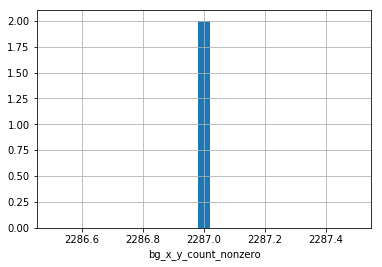

71   14.20 14.40 1      2290.000   2290.000  


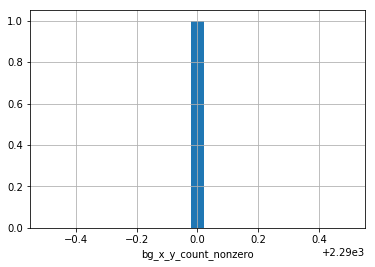

72   14.40 14.60 0      nan        nan       


In [64]:
mean_bg_mean_gz = []
mean_bg_x_y_count_nonzero_vals = []
median_bg_x_y_count_nonzero_vals = []
quantile_025_bg_x_y_count_nonzero_vals = []
quantile_975_bg_x_y_count_nonzero_vals = []
std_bg_x_y_count_nonzero_vals = []
count_bg_x_y_count_nonzero_vals = []

filtered_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id']).first()

bins_offset = 0 #filtered_df.bg_mean_gz.min()
bins_range_end = filtered_df.bg_mean_gz.max()
bin_width = 0.20

for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
    min_v = i*bin_width + bins_offset
    max_v = min_v + bin_width
    
    t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean_gz) & (filtered_df.bg_mean_gz < max_v)]
    print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
        i, min_v, max_v, len(t_filtered_df), t_filtered_df.bg_x_y_count_nonzero.min(), t_filtered_df.bg_x_y_count_nonzero.max()
    ))
    if len(t_filtered_df) > 0:
        h = t_filtered_df.bg_x_y_count_nonzero.hist(bins=25)
        h.set_xlabel('bg_x_y_count_nonzero')
        plt.show()
        
        mean_bg_mean_gz.append(np.mean([min_v,max_v]))
        mean_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.mean())
        median_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.median())
        quantile_025_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.quantile(0.025))
        quantile_975_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.quantile(0.975))
        std_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.std())
        count_bg_x_y_count_nonzero_vals.append(t_filtered_df.bg_x_y_count_nonzero.count())
    
# filtered_df 

# Visualizing background frames

In [65]:
import tool.npy_frames_visualization as npy_vis

In [66]:
inverse_means_map = np.load('/home/spbproc/euso-spb-patt-reco-v1/resources/inverse_flat_average_directions_4m_flipud.npy')

In [90]:
filtered_firstev_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id'], as_index=False).first()
events_to_vis_df = filtered_firstev_df.query('bg_mean > 4').sort_values(['bg_mean'])
events_to_vis_df

,source_file_acquisition_full,packet_id,event_id,source_file_acquisition,global_gtu,gtu_in_packet,num_gtu,gps_lat_mean,gps_lon_mean,gps_alt_mean,...,bg_norm_sum,bg_min,bg_max,bg_mean,bg_std,bg_mean_gz,bg_std_gz,bg_size,bg_median,bg_median_gz
34212,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,2,1529,allpackets-SPBEUSO-ACQUISITION-20170501-052308...,292,36,15,-33.1423,-156.065,29948.6,...,21658.10,0,17,4.64223,2.25837,4.74322,2.17536,36.0,4.48805,4.54621
34211,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,1,1495,allpackets-SPBEUSO-ACQUISITION-20170501-052308...,167,39,41,-33.1424,-156.066,29950.8,...,15135.60,0,25,4.64668,2.26336,4.74976,2.17872,36.0,4.50043,4.56175
34210,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,0,1445,allpackets-SPBEUSO-ACQUISITION-20170501-052308...,36,36,12,-33.1428,-156.068,29961.2,...,21914.90,0,17,4.65902,2.27766,4.76255,2.19316,36.0,4.50699,4.56870
34216,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,1,2926,allpackets-SPBEUSO-ACQUISITION-20170501-063138...,184,56,76,-32.9939,-155.571,27889.1,...,22665.00,0,17,4.81009,2.30783,4.90500,2.22836,36.0,4.66015,4.70823
34215,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,0,2875,allpackets-SPBEUSO-ACQUISITION-20170501-063138...,61,61,11,-32.9939,-155.572,27891.4,...,22603.10,0,17,4.83916,2.30998,4.92962,2.23379,36.0,4.67430,4.72090
34214,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,1,2832,allpackets-SPBEUSO-ACQUISITION-20170501-062938...,181,53,9,-32.9945,-155.583,28003.3,...,20775.30,0,20,5.06169,2.38099,5.14595,2.30866,36.0,4.89444,4.94217
34213,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,0,2771,allpackets-SPBEUSO-ACQUISITION-20170501-062938...,39,39,12,-32.9947,-155.585,28022.9,...,19404.60,0,21,5.12774,2.40275,5.21264,2.32943,36.0,4.95277,4.99513
22841,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,1,151237,allpackets-SPBEUSO-ACQUISITION-20170428-160759...,176,48,9,-37.4207,-172.258,27551.2,...,22266.20,0,25,6.87893,3.72425,7.77359,2.95284,36.0,7.12685,7.58276
33907,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,2,124458,allpackets-SPBEUSO-ACQUISITION-20170429-165010...,294,38,28,-36.1561,-169.778,22959.6,...,30374.60,0,35,12.97770,5.95729,14.06860,4.80877,36.0,13.83900,14.25370
33906,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,1,124439,allpackets-SPBEUSO-ACQUISITION-20170429-165010...,245,117,15,-36.1561,-169.778,22959.6,...,30733.10,0,35,12.98240,5.96700,14.05340,4.84679,36.0,13.86470,14.27930


#0	(0)
	event_id: 1529
	packet_id: 2
	gtu_in_packet: 36
	num_gtu: 15
	bg_mean: 4.64223
	gtu_datetime_min: 2017-05-01 05:23:48.701008
#1	(3)
	event_id: 1495
	packet_id: 1
	gtu_in_packet: 39
	num_gtu: 41
	bg_mean: 4.64668
	gtu_datetime_min: 2017-05-01 05:23:46.179952
#2	(6)
	event_id: 1445
	packet_id: 0
	gtu_in_packet: 36
	num_gtu: 12
	bg_mean: 4.65902
	gtu_datetime_min: 2017-05-01 05:23:31.566242
#3	(9)
	event_id: 2926
	packet_id: 1
	gtu_in_packet: 56
	num_gtu: 76
	bg_mean: 4.81009
	gtu_datetime_min: 2017-05-01 06:32:36.709002
#4	(12)
	event_id: 2875
	packet_id: 0
	gtu_in_packet: 61
	num_gtu: 11
	bg_mean: 4.83916
	gtu_datetime_min: 2017-05-01 06:32:27.773592
#5	(15)
	event_id: 2832
	packet_id: 1
	gtu_in_packet: 53
	num_gtu: 9
	bg_mean: 5.06169
	gtu_datetime_min: 2017-05-01 06:30:09.562545
#6	(18)
	event_id: 2771
	packet_id: 0
	gtu_in_packet: 39
	num_gtu: 12
	bg_mean: 5.12774
	gtu_datetime_min: 2017-05-01 06:29:51.687217
#7	(21)
	event_id: 151237
	packet_id: 1
	gtu_in_packet: 48
	num_gtu

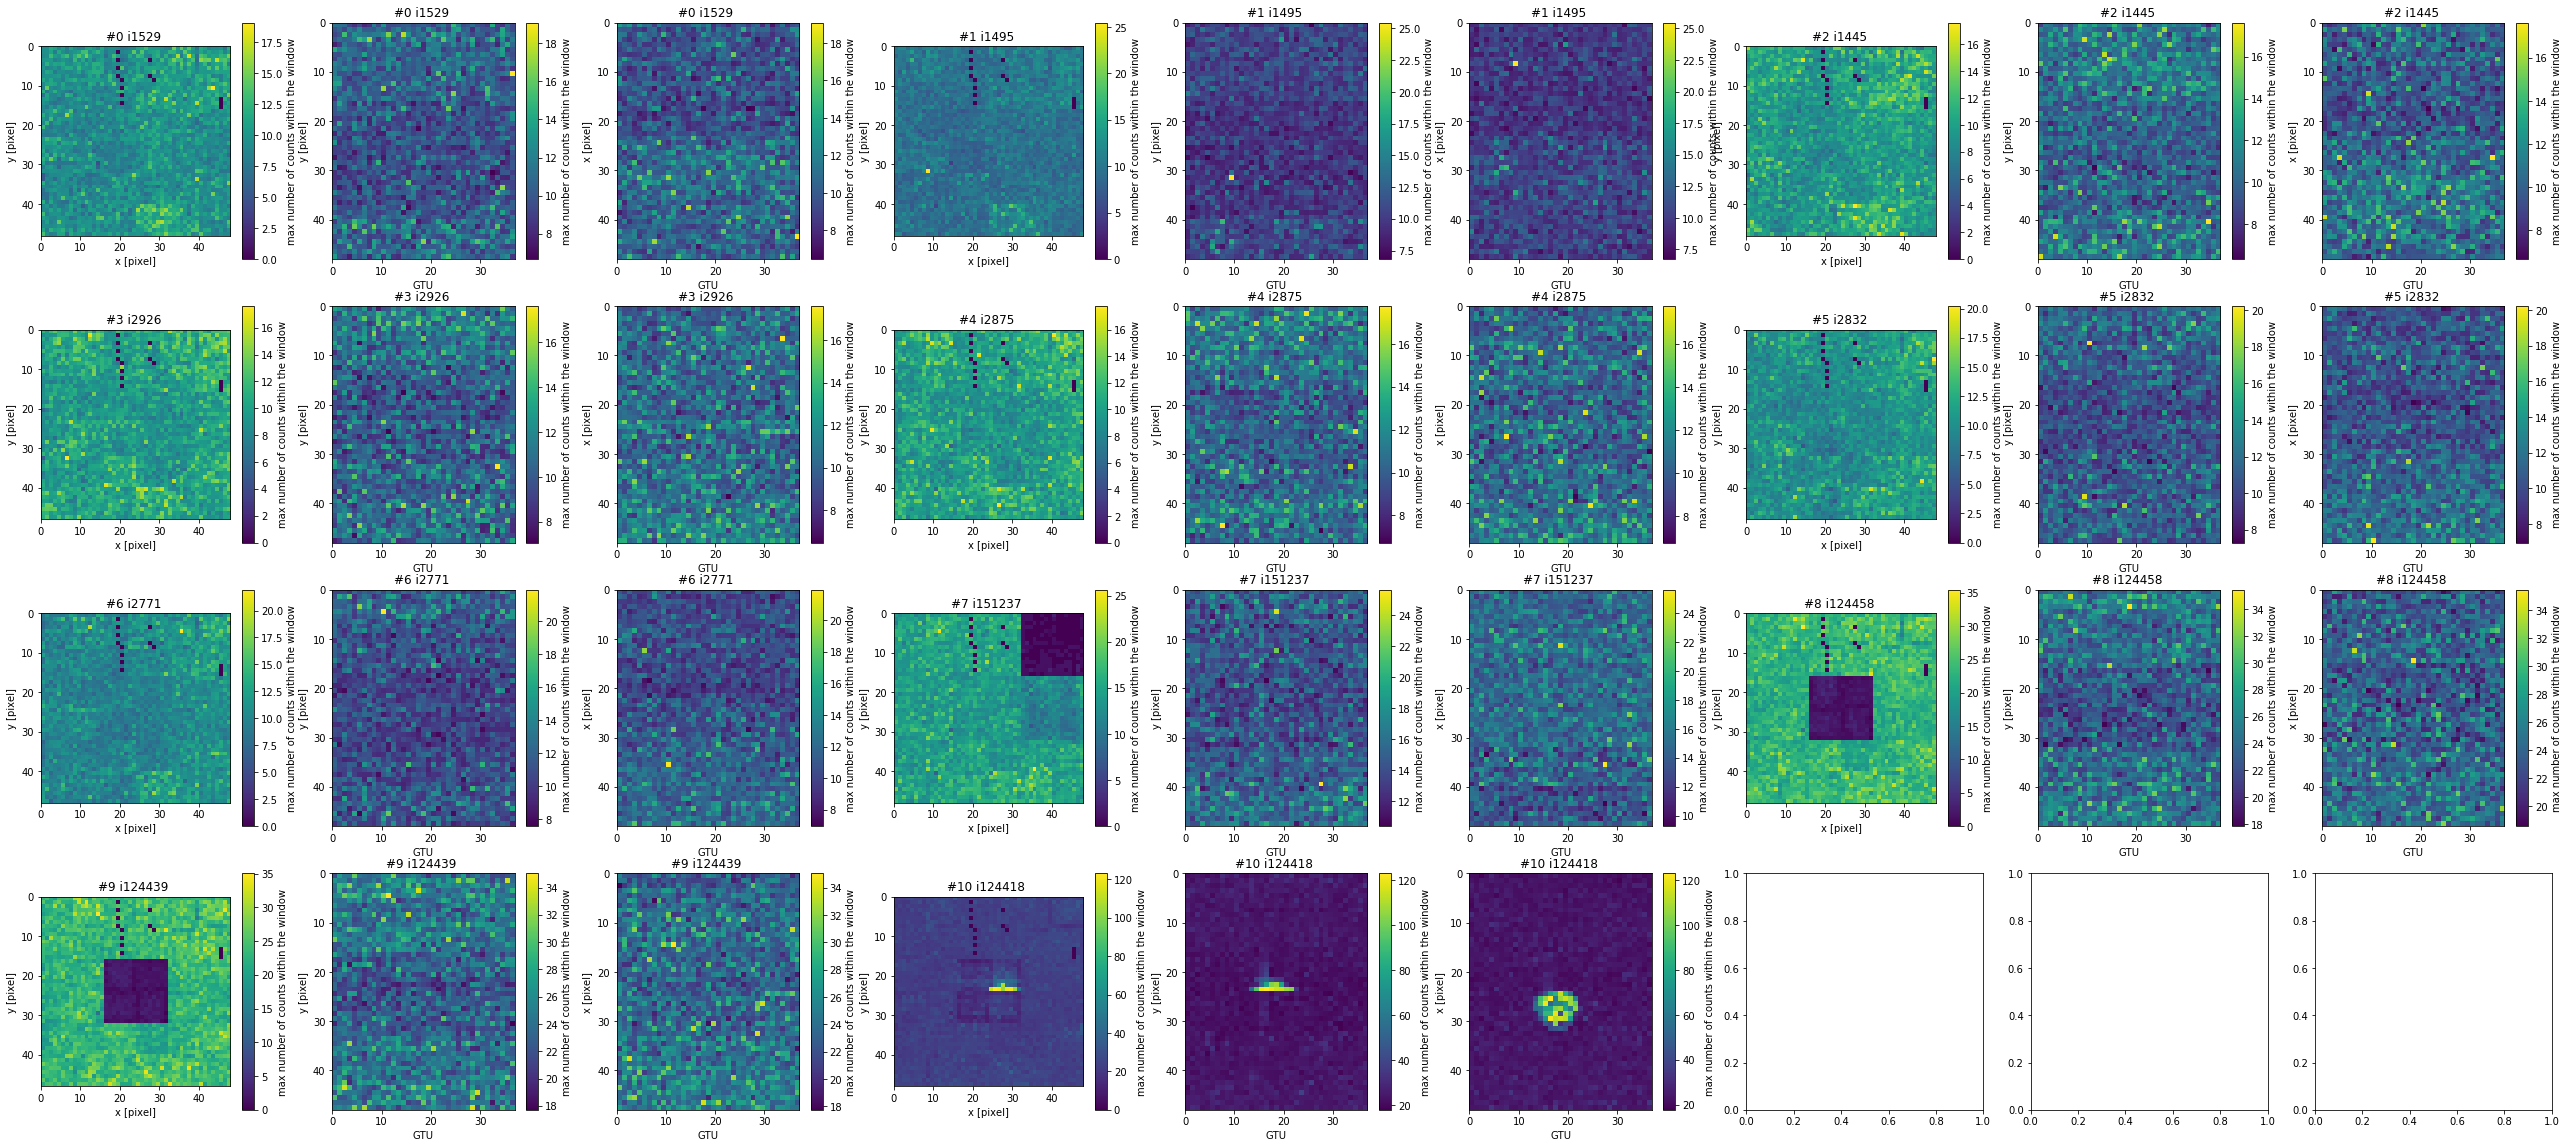

In [91]:
plt.close('all')
vis_events_df(events_to_vis_df, save_fig_dir=None, base_file_name='vis', 
              events_per_figure=min(50,len(events_to_vis_df)), max_figures=2,
              vis_gtux=True, vis_gtuy=True, close_after_vis=False, show=True,
              additional_printed_columns=['bg_mean','gtu_datetime_min'],
              get_first_frame_num_func=lambda r, c, packet_id_column, gtu_in_packet_column: \
                  r[c[packet_id_column]] * 128 + 0,
              get_last_frame_num_high_func=lambda r, c, packet_id_column, gtu_in_packet_column, num_gtu_column: \
                  r[c[packet_id_column]] * 128 + r[c['bg_size']] ,
              inverse_means_arr=inverse_means_map
             )

#0	(0)
	event_id: 1529
	packet_id: 2
	gtu_in_packet: 36
	num_gtu: 15
	bg_mean: 4.64223
	gtu_datetime_min: 2017-05-01 05:23:48.701008
#1	(3)
	event_id: 1495
	packet_id: 1
	gtu_in_packet: 39
	num_gtu: 41
	bg_mean: 4.64668
	gtu_datetime_min: 2017-05-01 05:23:46.179952
#2	(6)
	event_id: 1445
	packet_id: 0
	gtu_in_packet: 36
	num_gtu: 12
	bg_mean: 4.65902
	gtu_datetime_min: 2017-05-01 05:23:31.566242
#3	(9)
	event_id: 2926
	packet_id: 1
	gtu_in_packet: 56
	num_gtu: 76
	bg_mean: 4.81009
	gtu_datetime_min: 2017-05-01 06:32:36.709002
#4	(12)
	event_id: 2875
	packet_id: 0
	gtu_in_packet: 61
	num_gtu: 11
	bg_mean: 4.83916
	gtu_datetime_min: 2017-05-01 06:32:27.773592
#5	(15)
	event_id: 2832
	packet_id: 1
	gtu_in_packet: 53
	num_gtu: 9
	bg_mean: 5.06169
	gtu_datetime_min: 2017-05-01 06:30:09.562545
#6	(18)
	event_id: 2771
	packet_id: 0
	gtu_in_packet: 39
	num_gtu: 12
	bg_mean: 5.12774
	gtu_datetime_min: 2017-05-01 06:29:51.687217
#7	(21)
	event_id: 151237
	packet_id: 1
	gtu_in_packet: 48
	num_gtu

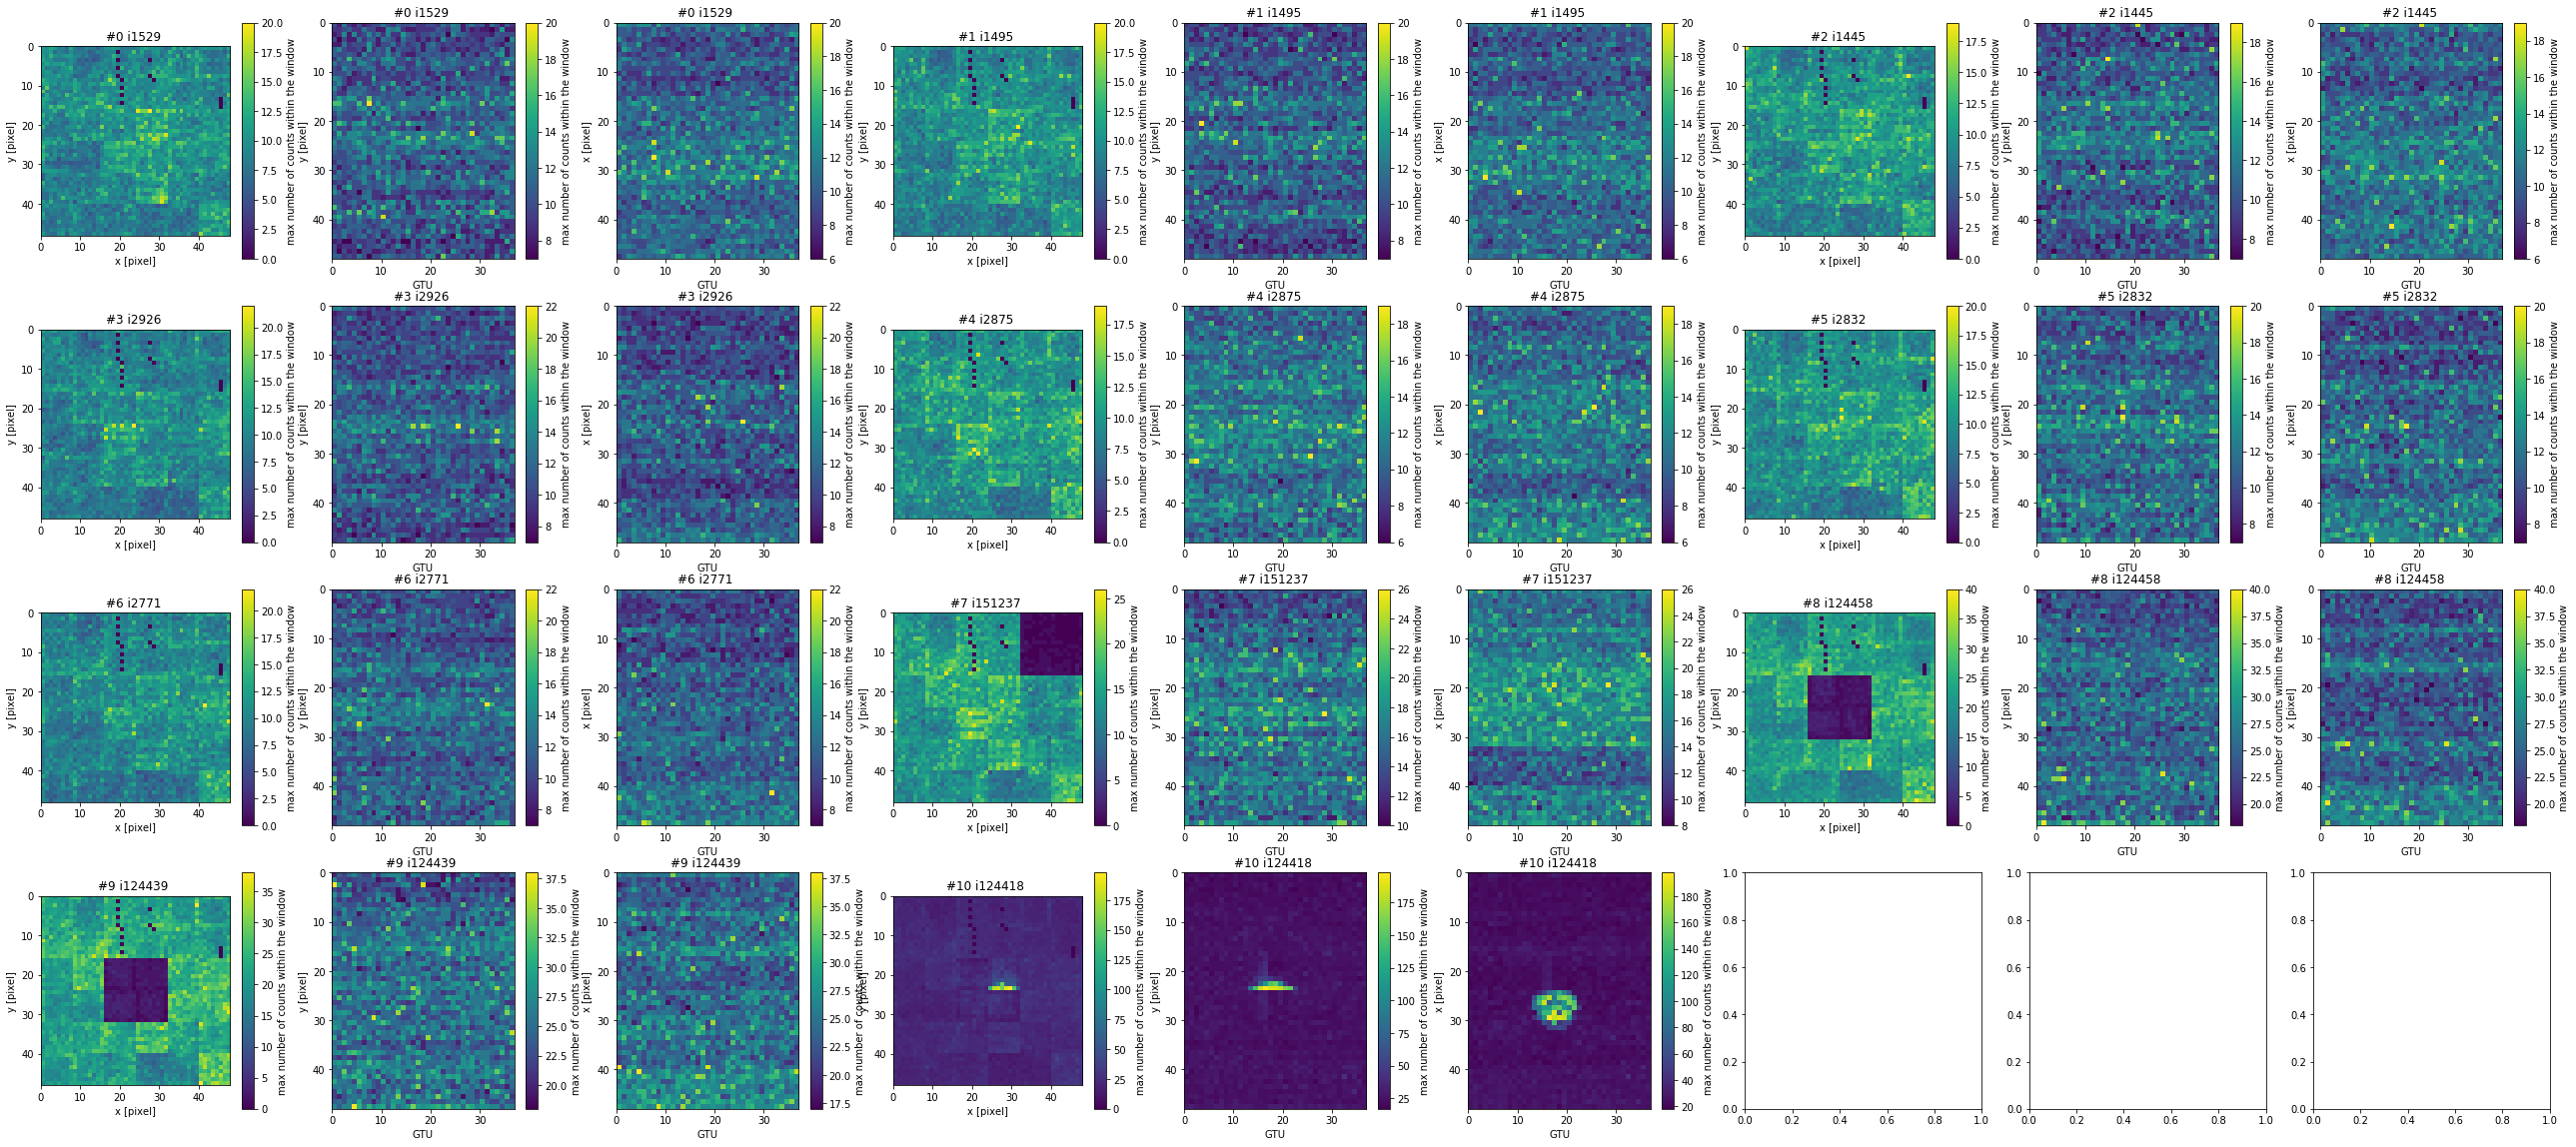

In [92]:
plt.close('all')
vis_events_df(events_to_vis_df, save_fig_dir=None, base_file_name='vis', 
              events_per_figure=min(50,len(events_to_vis_df)), max_figures=2,
              vis_gtux=True, vis_gtuy=True, close_after_vis=False, show=True,
              additional_printed_columns=['bg_mean','gtu_datetime_min'],
              get_first_frame_num_func=lambda r, c, packet_id_column, gtu_in_packet_column: \
                  r[c[packet_id_column]] * 128 + 0,
              get_last_frame_num_high_func=lambda r, c, packet_id_column, gtu_in_packet_column, num_gtu_column: \
                  r[c[packet_id_column]] * 128 + r[c['bg_size']] ,
              inverse_means_arr=None
             )

# Saving table of files and packets

In [70]:
remove_existing_files = True

In [71]:
acq_bg_tables_dirname = os.path.join(data_snippets_dir, 'acq_bg_tables')
os.makedirs(acq_bg_tables_dirname, exist_ok=True)

## binned bg_mean

In [72]:
# filtered_df = filtered_background_df
filtered_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id'], as_index=False).first()

table_for_bg_file_path = os.path.join(acq_bg_tables_dirname,'{}__bg_mean_all.tsv'.format(filtered_background_selection_basename_str))
if os.path.exists(table_for_bg_file_path):
    print('Removing\t{}'.format(table_for_bg_file_path))
print(table_for_bg_file_path)
num_uniq = 0
if len(filtered_df) > 0:
    with open(table_for_bg_file_path, 'w+') as table_for_bg_file:
        t_filtered_df_grouped = filtered_df.groupby('source_file_acquisition_full')
        for sfa, sfa_df in t_filtered_df_grouped:
            for r in sfa_df.packet_id.unique():
                num_uniq += 1
                print("{}\t{}".format(sfa, r), file=table_for_bg_file)
print("num_uniq =",num_uniq)

ver4_flatmap_data_snippets/acq_bg_tables/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_all.tsv
num_uniq = 35873


In [73]:
# filtered_df = filtered_background_df
filtered_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id'], as_index=False).first()

bins_offset = 0 #filtered_df.bg_mean_gz.min()
bins_range_end = filtered_df.bg_mean_gz.max()
# bin_width = 0.20

for bin_width in [0.1, 0.2, 0.5, 1.0]:

    table_for_bg_dir_path = os.path.join(acq_bg_tables_dirname,'bg_mean__{}_bins'.format(
        '{:.2f}'.format(bin_width).replace('.','_')
    ))
    os.makedirs(table_for_bg_dir_path, exist_ok=True)
    
    table_for_bg_file_path_format = os.path.join(table_for_bg_dir_path, filtered_background_selection_basename_str + '__bg_mean_{}.tsv')
    
    for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
        min_v = i*bin_width + bins_offset
        max_v = min_v + bin_width
        
        t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean) & (filtered_df.bg_mean < max_v)]
        print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
            i, min_v, max_v, len(t_filtered_df), t_filtered_df.gps_alt_mean.min(), t_filtered_df.gps_alt_mean.max()
        ))
        if len(t_filtered_df) > 0:
            t_filtered_df_grouped = t_filtered_df.groupby('source_file_acquisition_full')
            
            table_for_bg_file_path = table_for_bg_file_path_format.format(
                '{:.2f}'.format(np.mean([min_v,max_v])).replace('.','_'))
            print(table_for_bg_file_path)
            
            if os.path.exists(table_for_bg_file_path):
                print('Removing\t{}'.format(table_for_bg_file_path))
    
            num_uniq = 0
            with open(table_for_bg_file_path, 'w+') as table_for_bg_file:
                for sfa, sfa_df in t_filtered_df_grouped:
                    for r in sfa_df.packet_id.unique():
                        num_uniq += 1
                        print("{}\t{}".format(sfa, r), file=table_for_bg_file)
            print(num_uniq)
            
    print('-'*30)

0    0.00  0.10  0      nan        nan       
1    0.10  0.20  0      nan        nan       
2    0.20  0.30  0      nan        nan       
3    0.30  0.40  0      nan        nan       
4    0.40  0.50  0      nan        nan       
5    0.50  0.60  0      nan        nan       
6    0.60  0.70  0      nan        nan       
7    0.70  0.80  0      nan        nan       
8    0.80  0.90  0      nan        nan       
9    0.90  1.00  1554   21239.500  29824.000 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_10_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_0_95.tsv
1554
10   1.00  1.10  8165   21238.700  29824.000 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_10_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_1_05.tsv
8165
11   1.10  1.20  7289   19741.700  29590.900 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_10_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_1_15.tsv
7289
12   1.20  1.30  5414   16905.900  29700.800 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_10_bins/bg_

9762
7    1.40  1.60  4409   16837.600  28478.100 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_1_50.tsv
4409
8    1.60  1.80  2309   17820.800  27946.600 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_1_70.tsv
2309
9    1.80  2.00  1754   17936.100  27913.100 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_1_90.tsv
1754
10   2.00  2.20  329    18278.800  27832.600 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_2_10.tsv
329
11   2.20  2.40  80     18278.900  24414.500 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_2_30.tsv
80
12   2.40  2.60  192    19046.400  19084.700 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_2_50.tsv
192
13   2.60  2.80  0      nan        nan       

## binned bg_mean_gz

In [74]:
# filtered_df = filtered_background_df
filtered_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id'], as_index=False).first()

table_for_bg_file_path = os.path.join(acq_bg_tables_dirname,'{}__bg_mean_gz_all.tsv'.format(filtered_background_selection_basename_str))
if os.path.exists(table_for_bg_file_path):
    print('Removing\t{}'.format(table_for_bg_file_path))
print(table_for_bg_file_path)
num_uniq = 0
if len(filtered_df) > 0:
    with open(table_for_bg_file_path, 'w+') as table_for_bg_file:
        t_filtered_df_grouped = filtered_df.groupby('source_file_acquisition_full')
        for sfa, sfa_df in t_filtered_df_grouped:
            for r in sfa_df.packet_id.unique():
                num_uniq += 1
                print("{}\t{}".format(sfa, r), file=table_for_bg_file)
print("num_uniq =",num_uniq)

ver4_flatmap_data_snippets/acq_bg_tables/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_gz_all.tsv
num_uniq = 35873


In [75]:
# filtered_df = filtered_background_df
filtered_df = filtered_background_df.groupby(['source_file_acquisition_full', 'packet_id'], as_index=False).first()

bins_offset = 0 #filtered_df.bg_mean_gz.min()
bins_range_end = filtered_df.bg_mean_gz.max()
# bin_width = 0.20

for bin_width in [0.1, 0.2, 0.5, 1.0]:

    table_for_bg_dir_path = os.path.join(acq_bg_tables_dirname,'bg_mean_gz__{}_bins'.format(
        '{:.2f}'.format(bin_width).replace('.','_')
    ))
    os.makedirs(table_for_bg_dir_path, exist_ok=True)
    
    table_for_bg_file_path_format = os.path.join(table_for_bg_dir_path, filtered_background_selection_basename_str + '__bg_mean_gz_{}.tsv')
    

    for i in range(0,math.ceil((bins_range_end - bins_offset)/bin_width)+1):
        min_v = i*bin_width + bins_offset
        max_v = min_v + bin_width
        
        t_filtered_df = filtered_df[(min_v <= filtered_df.bg_mean_gz) & (filtered_df.bg_mean_gz < max_v)]
        print("{:<4d} {:<5.2f} {:<5.2f} {:<6d} {:<10.3f} {:<10.3f}".format(
            i, min_v, max_v, len(t_filtered_df), t_filtered_df.gps_alt_mean.min(), t_filtered_df.gps_alt_mean.max()
        ))
        if len(t_filtered_df) > 0:
            t_filtered_df_grouped = t_filtered_df.groupby('source_file_acquisition_full')
            
            table_for_bg_file_path = table_for_bg_file_path_format.format(
                '{:.2f}'.format(np.mean([min_v,max_v])).replace('.','_'))
            print(table_for_bg_file_path)
            
            if os.path.exists(table_for_bg_file_path):
                print('Removing\t{}'.format(table_for_bg_file_path))
    
            num_uniq = 0
            with open(table_for_bg_file_path, 'w+') as table_for_bg_file:
                for sfa, sfa_df in t_filtered_df_grouped:
                    for r in sfa_df.packet_id.unique():
                        num_uniq += 1
                        print("{}\t{}".format(sfa, r), file=table_for_bg_file)
            print(num_uniq)
            
    print('-'*30)

0    0.00  0.10  0      nan        nan       
1    0.10  0.20  0      nan        nan       
2    0.20  0.30  0      nan        nan       
3    0.30  0.40  0      nan        nan       
4    0.40  0.50  0      nan        nan       
5    0.50  0.60  0      nan        nan       
6    0.60  0.70  0      nan        nan       
7    0.70  0.80  0      nan        nan       
8    0.80  0.90  0      nan        nan       
9    0.90  1.00  0      nan        nan       
10   1.00  1.10  0      nan        nan       
11   1.10  1.20  0      nan        nan       
12   1.20  1.30  0      nan        nan       
13   1.30  1.40  0      nan        nan       
14   1.40  1.50  0      nan        nan       
15   1.50  1.60  843    21298.900  29824.000 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean_gz__0_10_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_gz_1_55.tsv
843
16   1.60  1.70  10885  21220.200  29824.000 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean_gz__0_10_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mea

9979
10   2.00  2.20  3276   16837.600  28378.000 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean_gz__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_gz_2_10.tsv
3276
11   2.20  2.40  2114   17936.100  27944.700 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean_gz__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_gz_2_30.tsv
2114
12   2.40  2.60  316    18278.800  24459.800 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean_gz__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_gz_2_50.tsv
316
13   2.60  2.80  180    18278.900  19084.700 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean_gz__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_gz_2_70.tsv
180
14   2.80  3.00  38     19047.400  19083.800 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean_gz__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_gz_2_90.tsv
38
15   3.00  3.20  4      18871.600  18881.800 
ver4_flatmap_data_snippets/acq_bg_tables/bg_mean_gz__0_20_bins/bg_size_ge_36__bg_x_y_gt_2100__bg_mean_gz_3_10.tsv
4
16   3.20  3

In [76]:
import seaborn

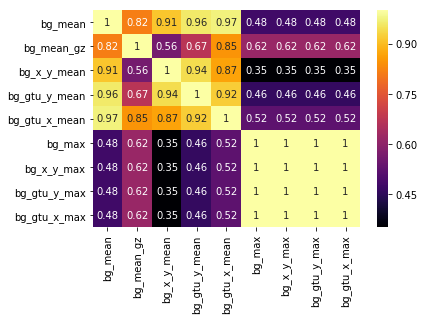

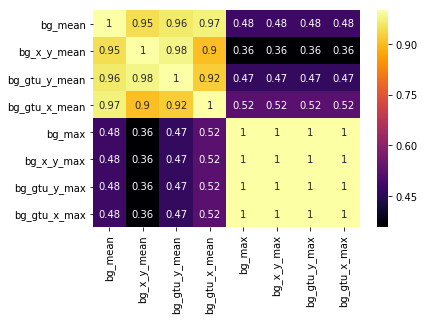

In [77]:
flight_data_corr_df = flight_data_df[['bg_mean','bg_mean_gz','bg_x_y_mean','bg_gtu_y_mean','bg_gtu_x_mean',
                                      'bg_max','bg_x_y_max','bg_gtu_y_max','bg_gtu_x_max']].corr()
f, ax = plt.subplots(figsize=(28,22))

#Draw the heatmap using seaborn
plt.close('all')
seaborn.heatmap(flight_data_corr_df, cmap='inferno', annot=True)
plt.show()

filtered_df = flight_data_df[(flight_data_df.bg_size >= 36) & (flight_data_df.gtu_in_packet >= 40)]
flight_data_corr_df = filtered_df[['bg_mean','bg_x_y_mean','bg_gtu_y_mean','bg_gtu_x_mean',
                                      'bg_max','bg_x_y_max','bg_gtu_y_max','bg_gtu_x_max']].corr()
f, ax = plt.subplots(figsize=(28,22))

#Draw the heatmap using seaborn
plt.close('all')
seaborn.heatmap(flight_data_corr_df, cmap='inferno', annot=True)
plt.show()

In [78]:
# current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

# select_clause_str, joined_tables_list = \
#     query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
# join_clauses_str = \
#     query_functions.get_query_clauses__join(joined_tables_list)
# where_clauses_str = ' AND config_info_id=2'
    
# events_selection_query = query_functions.get_events_selection_query_plain(
#     source_data_type_num=1,
#     select_additional=select_clause_str, join_additional=join_clauses_str,
#     where_additional=where_clauses_str,
#     order_by='{data_table_name}.event_id', limit=350000, offset=0,
#     base_select='',
#     data_table_name_overwrite=events_data_table_name)

# flight_data_2_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [79]:
# plt.close('all')
# # fig, ax = plt.subplots(1,1)
# h = flight_data_2_df.bg_x_y_mean_gz.hist()
# h.set_yscale('log')
# plt.show()